<b>MATH 1130A Term Project<br/>
Credit Default Risk Analysis<br/>
Group A</b><br/>
<p>Read in and perform EDA and data analysis on the credit default data files. This includes the current loan application and previous loan application files.
</p>


In [485]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [486]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Option to change max columns pd can display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)


In [487]:
# Change this to where you store your datasets
DATA_DIR = "/content/drive/MyDrive/datasets"

In [488]:
# Load current loan application data from a CSV file
app = pd.read_csv(f"{DATA_DIR}/application_data.csv")

# Load previous loan applications data from a CSV file
app_prev = pd.read_csv(f"{DATA_DIR}/previous_application.csv")

## EDA & Cleaning - `app` DataFrame

**General direction**:
- We decide to approach this classification problem with a gradient based decision tree model, like **XGBoost**. We believe that the algorithm will solve the requirements, such as providing a classification, as well as highlighting the top important features.

This implies the following:

**Handling missing values**:
- **XGBoost** is by nature quite robust to missing values, as it can try to interpolate during the tree building steps.
- In the best cases, we can impute *Missing at random (MAR)* or *MISSING not at random (MNAR)* columns if we detect any patterns.
- In the case of *Missing completely at random (MCAR)*, or the amount of missing data is too much, we will delete the columns, as there is a limit to handling missing **XGBoost** has.

**Imbalanced features** (not class labels):
- **XGBoost** is generally robust to imbalanced features.

**Imbalanced class**:
- **XGBoost** is vulnerable to class imbalance as it tends to favour the majority class. We should focusing on handling this, and use appropriate metrics to evaluate our model like **ROC AUC**.

**Sidenote**
- There are a few common default values that are not explicitly defined. "XNA" means Not Available, and "XAP" means Not Applicable.


In [489]:
# Checks for XNA/XAP values, use when pd.Series.value_counts() is not effective
def checkXnaXap(df, col_name):
    return df[df[col_name] == 'XNA'].shape[0], df[df[col_name] == 'XAP'].shape[0]

In [490]:
print(app.dtypes)

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [491]:
app.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

### TARGET - Our classification label

<Axes: xlabel='TARGET', ylabel='count'>

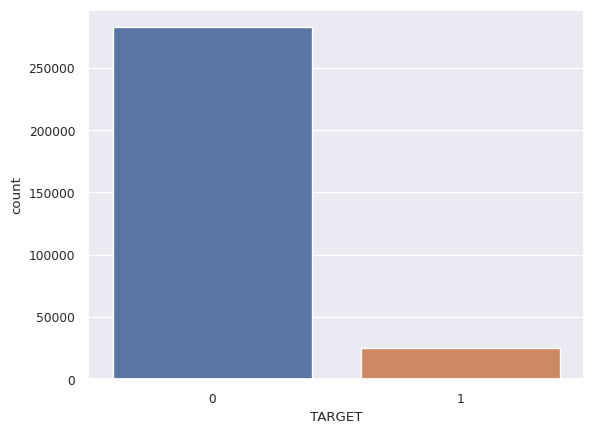

In [492]:
# We can immediately see the class imbalance, which will affect our metrics later on
# ROC-AUC is recommended metrics for classification
# Lucklily there is no missing label

sns.countplot(x='TARGET', data=app)

In [493]:
(app['TARGET'] == 0).sum() / (app['TARGET'] == 1).sum()

11.387150050352467

### NAME_CONTRACT_TYPE

In [494]:
app.NAME_CONTRACT_TYPE.value_counts(dropna=False)

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

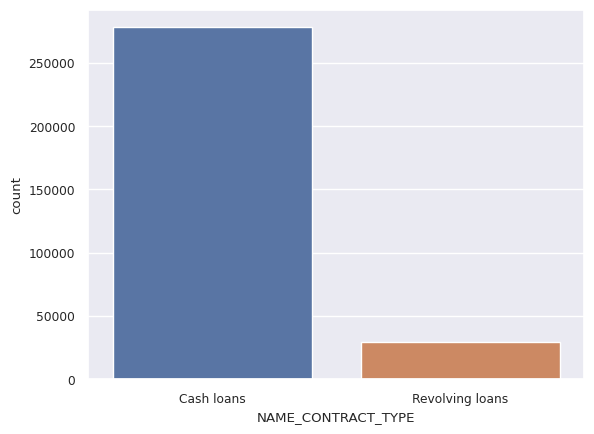

In [495]:
sns.countplot(x="NAME_CONTRACT_TYPE", data=app)

### CODE_GENDER - n

In [496]:
app.CODE_GENDER.value_counts(dropna=False)

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

**Observation**: This is MCAR. Since only a few columns are affected, we can let the model decide.

In [497]:
# convert XNA code_gender to null
app.CODE_GENDER = app.CODE_GENDER.replace('XNA', np.nan)

<Axes: xlabel='CODE_GENDER', ylabel='count'>

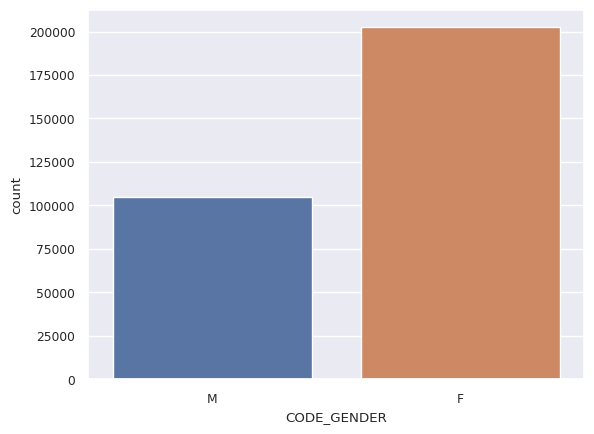

In [498]:
sns.countplot(x="CODE_GENDER", data=app)

**Observation**: Interesting how there are double the female applications to males.

### FLAG_OWN_CAR

In [499]:
app.FLAG_OWN_CAR.value_counts(dropna=False)

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

<Axes: xlabel='FLAG_OWN_CAR', ylabel='count'>

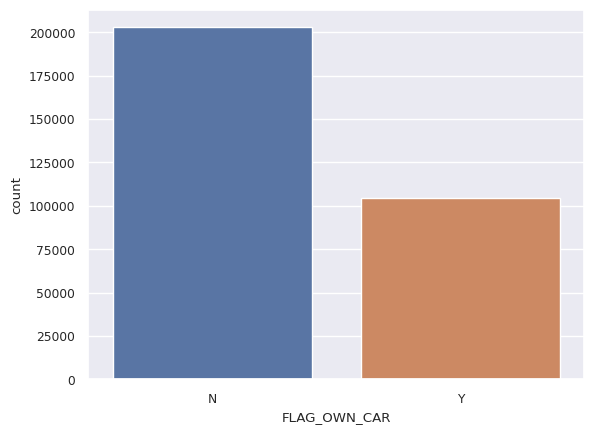

In [500]:
sns.countplot(x="FLAG_OWN_CAR", data=app)

### FLAG_OWN_REALTY

In [501]:
app.FLAG_OWN_REALTY.value_counts(dropna=False)

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

<Axes: xlabel='FLAG_OWN_REALTY', ylabel='count'>

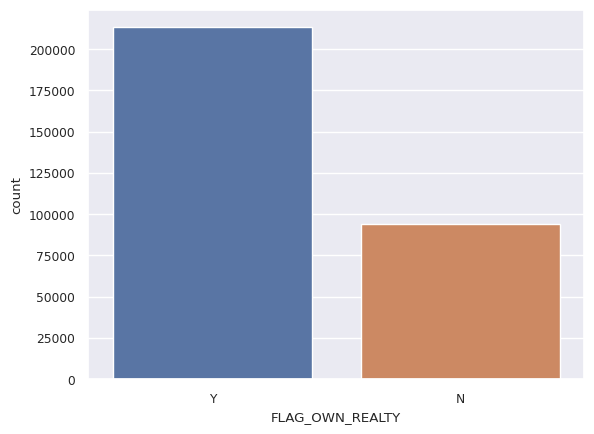

In [502]:
sns.countplot(x="FLAG_OWN_REALTY", data=app)

### CNT_CHILDREN - o

In [503]:
app.CNT_CHILDREN.value_counts(dropna=False)

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

<Axes: xlabel='CNT_CHILDREN', ylabel='count'>

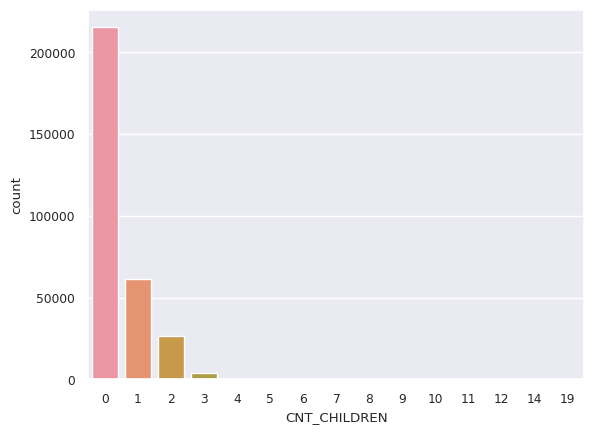

In [504]:
sns.countplot(x="CNT_CHILDREN", data=app)

**Observation**: We can see that `CNT_CHILDREN` >= 7 are outliers

<Axes: xlabel='CNT_CHILDREN', ylabel='count'>

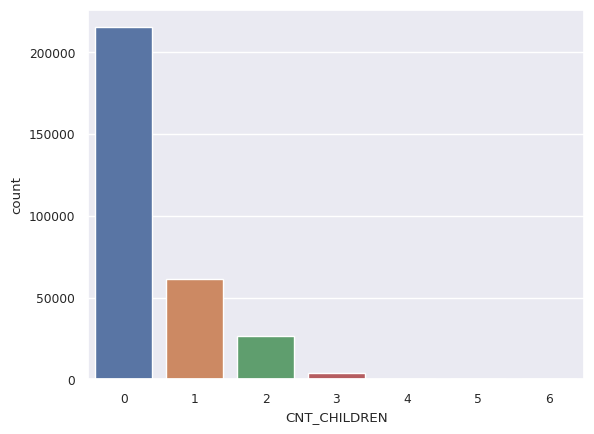

In [505]:
app = app[app.CNT_CHILDREN < 7]
# Plot the chart again
sns.countplot(x="CNT_CHILDREN", data=app)

### AMT_INCOME_TOTAL - o

In [506]:
# check for XNA or XAP values
checkXnaXap(app, 'AMT_INCOME_TOTAL')

(0, 0)

<Axes: >

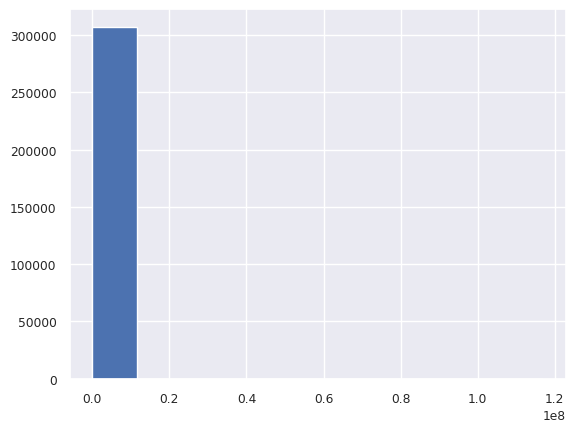

In [507]:
app.AMT_INCOME_TOTAL.hist()

**Observation**: There seems to be income outliers. We think very high income cases should be investigated further and be removed from our dataset

In [508]:
# 99.99 percentile of AMT_INCOME_TOTAL
app.AMT_INCOME_TOTAL.quantile(0.999)

900000.0

In [509]:
app = app[app.AMT_INCOME_TOTAL < app.AMT_INCOME_TOTAL.quantile(0.999)]

<Axes: >

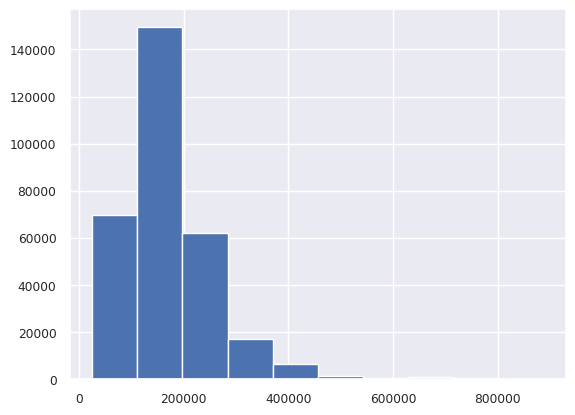

In [510]:
# Plot the chart again
app.AMT_INCOME_TOTAL.hist()

### AMT_CREDIT - o

In [511]:
# check for XNA or XAP values
checkXnaXap(app, 'AMT_CREDIT')

(0, 0)

<Axes: >

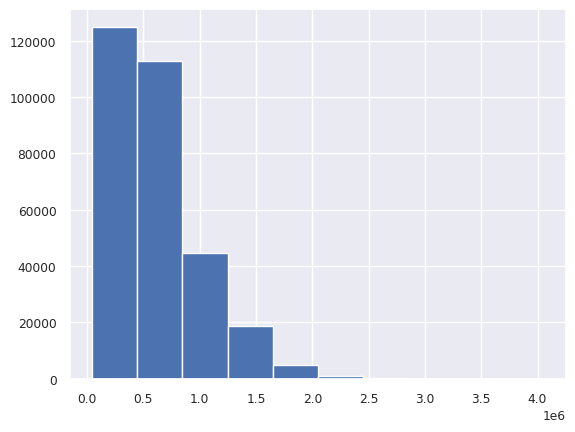

In [512]:
app.AMT_CREDIT.hist()

**Observation**: There seems to be income outliers. We think very high credit cases should be investigated further and be removed from our dataset

In [513]:
# 99.9 percentile of AMT_CREDIT
app.AMT_CREDIT.quantile(0.999)

2517300.0

<Axes: >

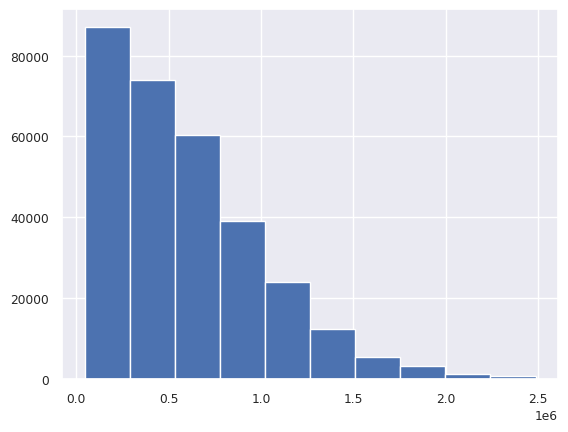

In [514]:
app = app[app.AMT_CREDIT < app.AMT_CREDIT.quantile(0.999)]
app.AMT_CREDIT.hist()

### AMT_ANNUITY - n, o

In [515]:
# AMT_ANNUITY null vs non null count
app['AMT_ANNUITY'].isnull().value_counts()

False    306680
True         12
Name: AMT_ANNUITY, dtype: int64

**Observation**: This is MCAR. Since only a few columns are affected, we can let the model decide.

<Axes: >

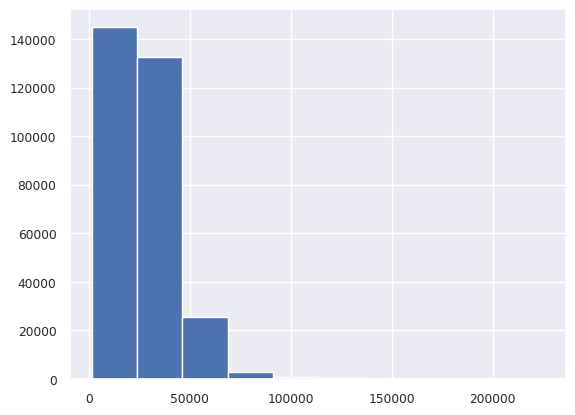

In [516]:
app.AMT_ANNUITY.hist()

**Observation**: There seems to be income outliers. We think very high annuity amount cases should be investigated further and be removed from our dataset

In [517]:
# 99.9 percentile of AMT_ANNUITY
app.AMT_ANNUITY.quantile(0.999)

108085.89150001152

<Axes: >

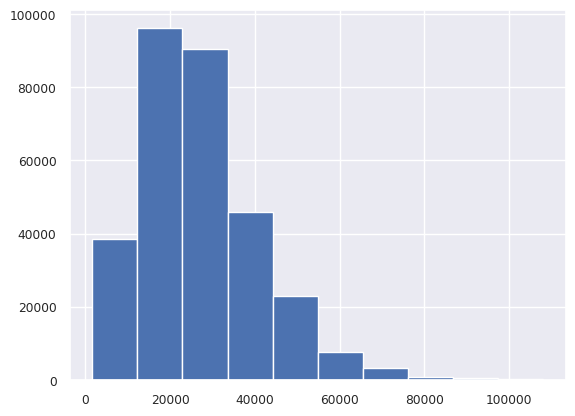

In [518]:
app = app[app.AMT_ANNUITY < app.AMT_ANNUITY.quantile(0.999)]
app.AMT_ANNUITY.hist()

### AMT_GOODS_PRICE - n

In [519]:
# AMT_GOODS_PRICE null vs non null count
app['AMT_GOODS_PRICE'].isnull().value_counts()

False    306095
True        278
Name: AMT_GOODS_PRICE, dtype: int64

In [520]:
# AMT_GOODS_PRICE null with Revolving loans contract type
app[app['AMT_GOODS_PRICE'].isnull()]['NAME_CONTRACT_TYPE'].value_counts()

Revolving loans    278
Name: NAME_CONTRACT_TYPE, dtype: int64

**Observation**: Missing values in AMT_GOODS_PRICE are all revolving loans (MAR), so we can fill them with 0, i.e. no goods price

In [521]:
# Missing values in AMT_GOODS_PRICE are all revolving loans, so we can fill them with 0, i.e. no goods price
app['AMT_GOODS_PRICE'].fillna(0, inplace=True)

<Axes: >

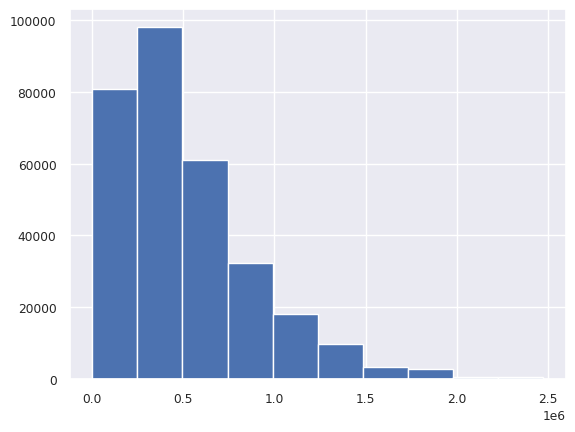

In [522]:
app.AMT_GOODS_PRICE.hist()

### NAME_TYPE_SUITE - n

In [523]:
app.NAME_TYPE_SUITE.value_counts(dropna=False)

Unaccompanied      247579
Family              40034
Spouse, partner     11329
Children             3259
Other_B              1764
NaN                  1276
Other_A               862
Group of people       270
Name: NAME_TYPE_SUITE, dtype: int64

**Observation**: This is MCAR. Since only a few columns are affected, we can let the model decide.

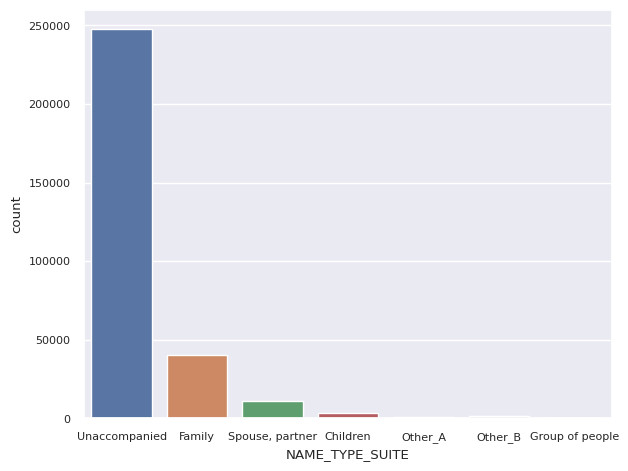

In [524]:
sns.countplot(x="NAME_TYPE_SUITE", data=app)
# smaller font size for xticks and yticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# space between plots
plt.tight_layout()

### NAME_INCOME_TYPE

In [525]:
app['NAME_INCOME_TYPE'].value_counts()

Working                 158434
Commercial associate     71023
Pensioner                55268
State servant            21597
Unemployed                  22
Student                     18
Businessman                  6
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [526]:
app['NAME_INCOME_TYPE'].isnull().value_counts()

False    306373
Name: NAME_INCOME_TYPE, dtype: int64

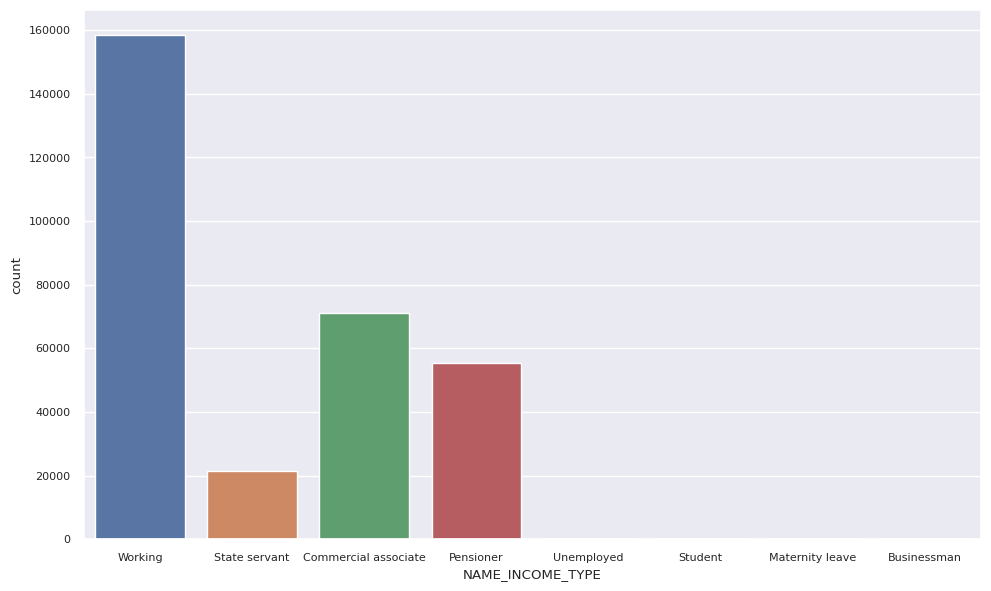

In [527]:
plt.figure(figsize=(10,6))
sns.countplot(x="NAME_INCOME_TYPE", data=app)
# smaller font size for xticks and yticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# space between plots
plt.tight_layout()

### NAME_EDUCATION_TYPE $

In [528]:
app.NAME_EDUCATION_TYPE.value_counts(dropna=False)

Secondary / secondary special    218038
Higher education                  74119
Incomplete higher                 10245
Lower secondary                    3809
Academic degree                     162
Name: NAME_EDUCATION_TYPE, dtype: int64

**Observation**: This is a categorical feature with inherent ordering

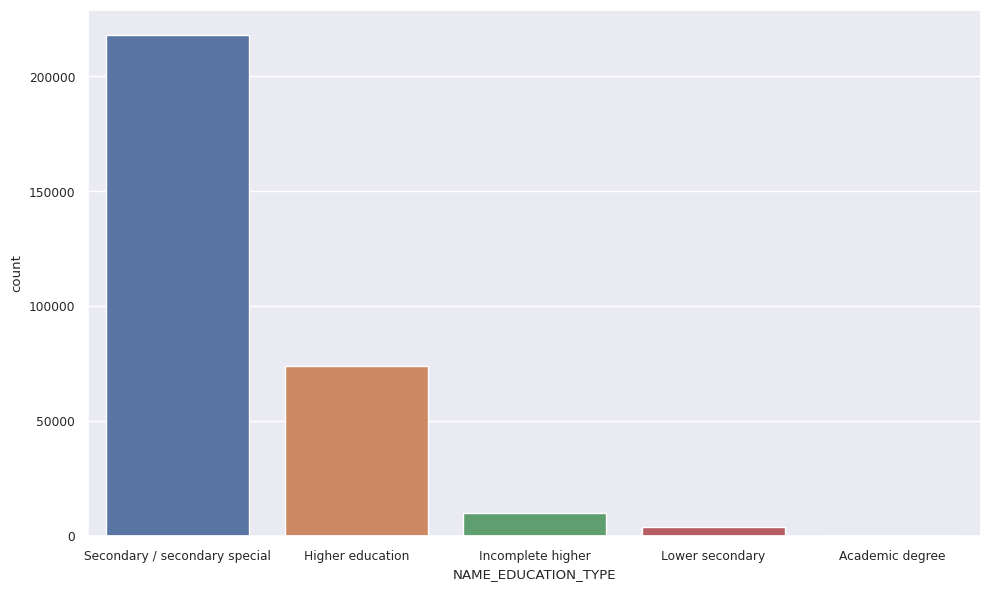

In [529]:
plt.figure(figsize=(10,6))
sns.countplot(x="NAME_EDUCATION_TYPE", data=app)
# smaller font size for xticks and yticks
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# space between plots
plt.tight_layout()

### NAME_FAMILY_STATUS - n

In [530]:
app.NAME_FAMILY_STATUS.value_counts(dropna=False)

Married                 195613
Single / not married     45300
Civil marriage           29694
Separated                19697
Widow                    16067
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

**Observation**: This is MCAR. Since only a few columns are affected, we can let the model decide.

In [531]:
# convert "Unknown" to null
app.NAME_FAMILY_STATUS = app.NAME_FAMILY_STATUS.replace('Unknown', np.nan)

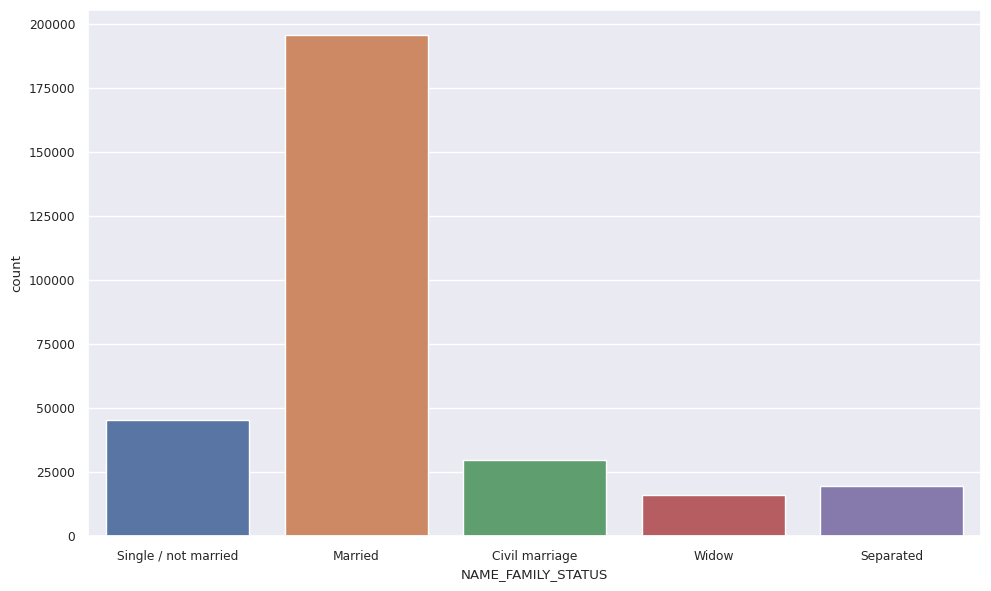

In [532]:
plt.figure(figsize=(10,6))
sns.countplot(x="NAME_FAMILY_STATUS", data=app)
# smaller font size for xticks and yticks
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# space between plots
plt.tight_layout()

### NAME_HOUSING_TYPE   

In [533]:
app.NAME_HOUSING_TYPE.value_counts(dropna=False)

House / apartment      271815
With parents            14810
Municipal apartment     11155
Rented apartment         4866
Office apartment         2607
Co-op apartment          1120
Name: NAME_HOUSING_TYPE, dtype: int64

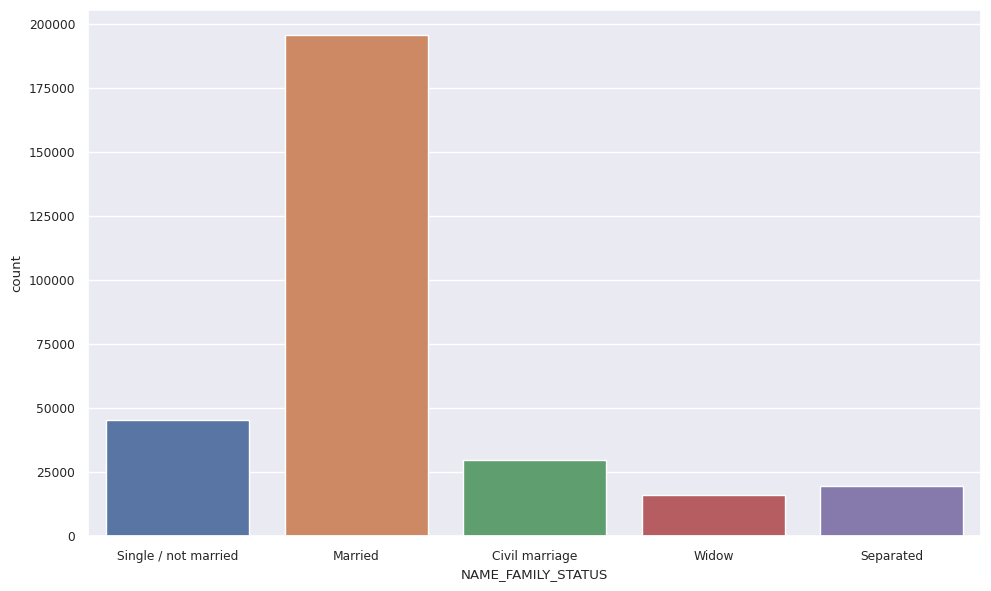

In [534]:
plt.figure(figsize=(10,6))
sns.countplot(x="NAME_FAMILY_STATUS", data=app)
# smaller font size for xticks and yticks
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# space between plots
plt.tight_layout()

### REGION_POPULATION_RELATIVE

In [535]:
app.REGION_POPULATION_RELATIVE.describe()

count    306373.000000
mean          0.020830
std           0.013771
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

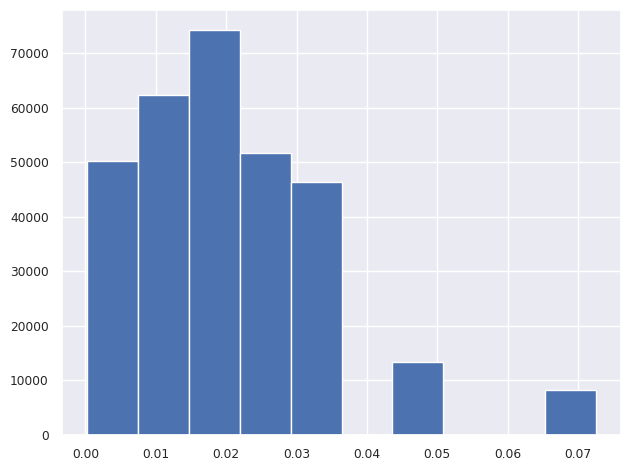

In [536]:
app['REGION_POPULATION_RELATIVE'].hist()
# smaller font size for xticks and yticks
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# space between plots
plt.tight_layout()

### DAYS_BIRTH $

In [537]:
checkXnaXap(app, "DAYS_BIRTH")

(0, 0)

In [538]:
app.DAYS_BIRTH.describe()

count    306373.000000
mean     -16036.467358
std        4366.352251
min      -25201.000000
25%      -19684.000000
50%      -15749.000000
75%      -12409.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

<Axes: >

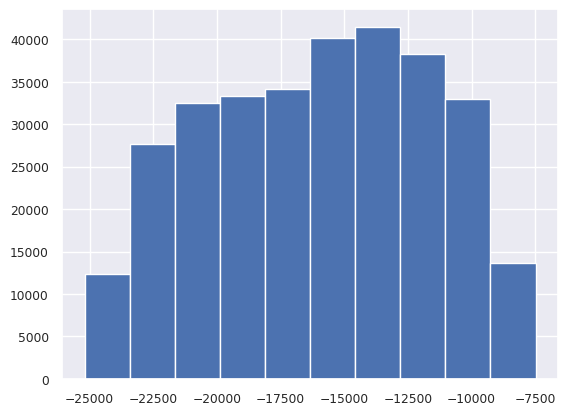

In [539]:
app.DAYS_BIRTH.hist()

### DAYS_EMPLOYED $ - o

In [540]:
app.DAYS_EMPLOYED.describe()

count    306373.000000
mean      63949.678878
std      141385.726213
min      -17912.000000
25%       -2757.000000
50%       -1211.000000
75%        -288.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

<Axes: >

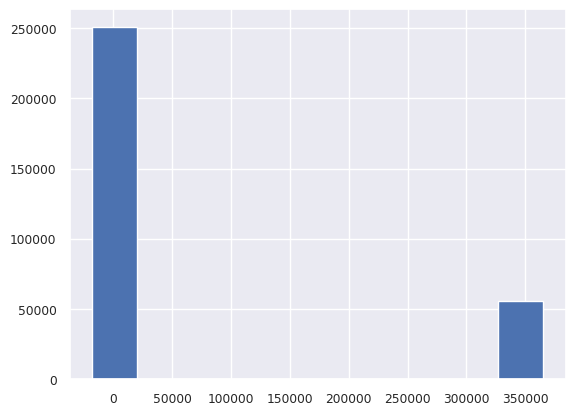

In [541]:
app.DAYS_EMPLOYED.hist()

**Observation**: The value 365243 is very interesting here, as this feature should be negative numbers.

In [542]:
# We now learn that 365243 means people who are pensioners
# check if they have a job
app[app['DAYS_EMPLOYED'] == 365243]['NAME_INCOME_TYPE'].value_counts()

Pensioner     55258
Unemployed       22
Name: NAME_INCOME_TYPE, dtype: int64

In [543]:
# how many pensioners are there
app[app['NAME_INCOME_TYPE'] == 'Pensioner'].shape[0]

55268

In [544]:
# pensioner with DAYS_EMPLOYED != 365243
app[(app['NAME_INCOME_TYPE'] == 'Pensioner') & (app['DAYS_EMPLOYED'] != 365243)].shape

(10, 122)

In [545]:
# convert pensioner with DAYS_EMPLOYED != 365243 to 365243
app.loc[(app['NAME_INCOME_TYPE'] == 'Pensioner') & (app['DAYS_EMPLOYED'] != 365243), 'DAYS_EMPLOYED'] = 365243

**Big Question**: Should we do something about this?

Maybe not. The value `365243` is inherently different from the rest of the values since it indicates retirements. The model should be able to differentiate people who retired and who don't, using this unique numerical code `365243`.

We also don't want to turn this value into NaN since the model may think NaN is missing data and try to impute.

Lastly, we should definitely create another column to indicate retirement to help the model.

### DAYS_REGISTRATION, DAYS_ID_PUBLISH

<Axes: >

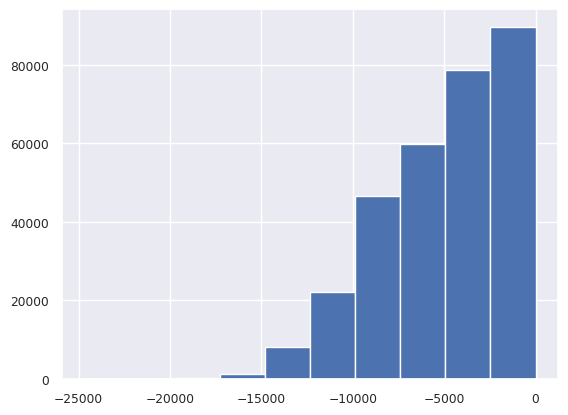

In [546]:
app.DAYS_REGISTRATION.hist()

<Axes: >

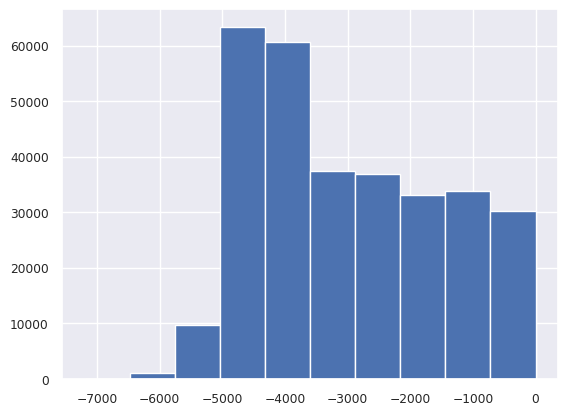

In [547]:
app.DAYS_ID_PUBLISH.hist()

### OWN_CAR_AGE - n


In [548]:
app.OWN_CAR_AGE.describe()

count    103903.000000
mean         12.094819
std          11.960648
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

<Axes: >

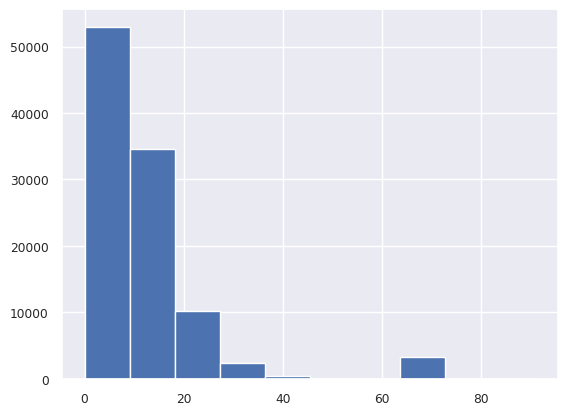

In [549]:
app.OWN_CAR_AGE.hist()

In [550]:
app.OWN_CAR_AGE.isnull().value_counts()

True     202470
False    103903
Name: OWN_CAR_AGE, dtype: int64

**Observation**: We assume that `OWN_CAR_AGE == Null` means no car (MNAR)

In [551]:
app.OWN_CAR_AGE.fillna(0, inplace=True)

<Axes: >

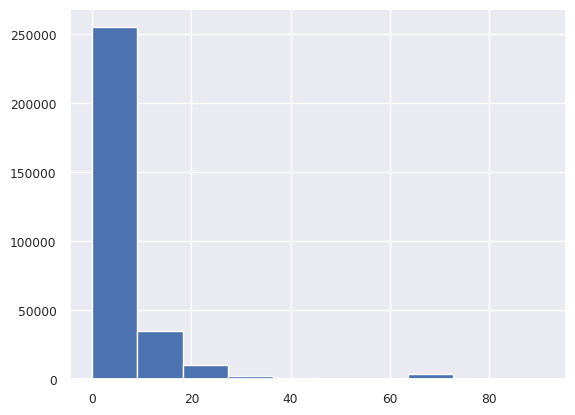

In [552]:
app.OWN_CAR_AGE.hist()

### Columns about Contact Info Flags

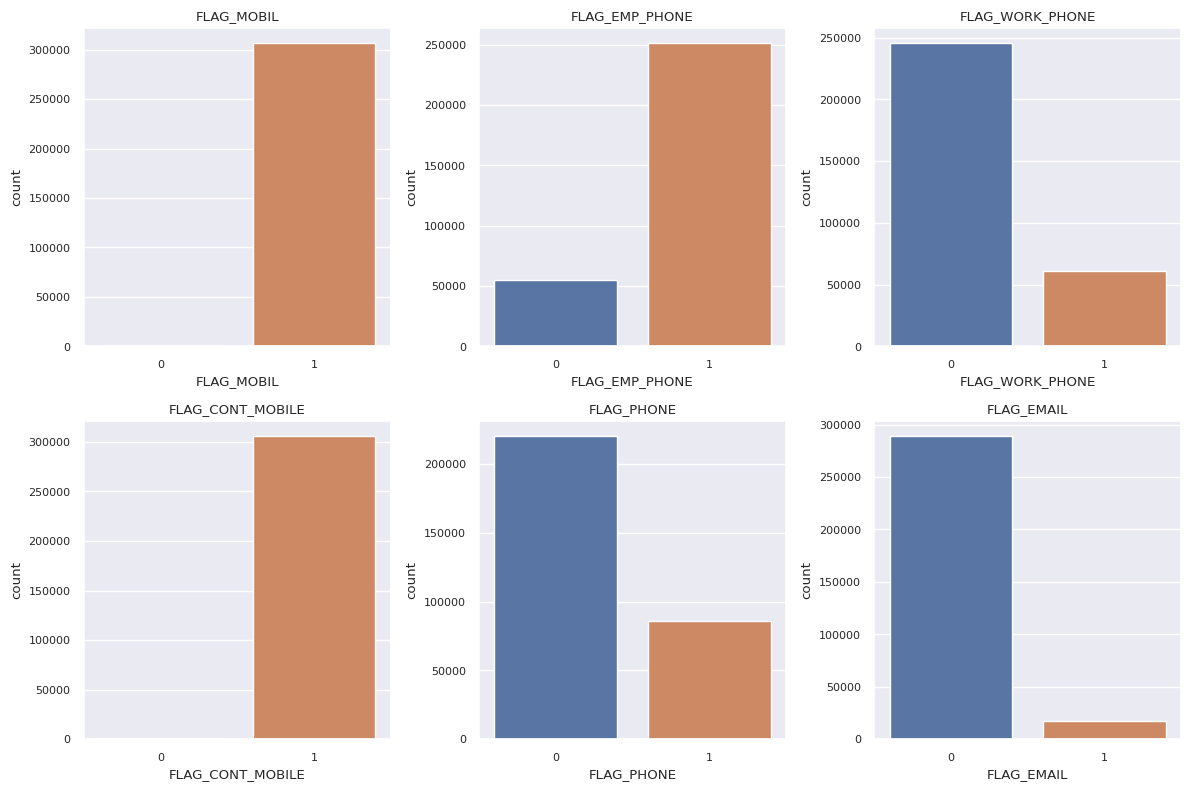

In [553]:
plt.figure(figsize=(12,8))

for i, col in enumerate([
        "FLAG_MOBIL",
        "FLAG_EMP_PHONE",
        "FLAG_WORK_PHONE",
        "FLAG_CONT_MOBILE",
        "FLAG_PHONE",
        "FLAG_EMAIL",
    ]
):
    ax = plt.subplot(2, 3, i+1)
    sns.countplot(x=col, data=app, ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

In [554]:
app.FLAG_MOBIL.value_counts()

1    306372
0         1
Name: FLAG_MOBIL, dtype: int64

**Observation**: We can discard this column due to having only 1 records for `0`

In [555]:
app.drop(['FLAG_MOBIL'], axis=1, inplace=True)

### OCCUPATION_TYPE

In [556]:
app.OCCUPATION_TYPE.value_counts(dropna=False)

NaN                      96151
Laborers                 55107
Sales staff              32045
Core staff               27466
Managers                 20920
Drivers                  18573
High skill tech staff    11334
Accountants               9744
Medicine staff            8523
Security staff            6707
Cooking staff             5940
Cleaning staff            4649
Private service staff     2644
Low-skill Laborers        2092
Waiters/barmen staff      1347
Secretaries               1300
Realty agents              750
HR staff                   561
IT staff                   520
Name: OCCUPATION_TYPE, dtype: int64

In [557]:
app[app['OCCUPATION_TYPE'].isnull()]['NAME_INCOME_TYPE'].value_counts(dropna=False)

Pensioner               55263
Working                 24879
Commercial associate    12214
State servant            3765
Unemployed                 22
Student                     5
Businessman                 2
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

In [558]:
app[app['OCCUPATION_TYPE'].isnull()]['NAME_INCOME_TYPE'].value_counts(dropna=False).sum()

96151

**Big question**: Those with `NaN` values, who are they?

We have 2 Theories:
1. There are pensioner
2. Their job is not in the list of OCCUPATION_TYPE

This is MNAR and we should try to impute

In [559]:
# convert those with NAME_INCOME_TYPE == 'Pensioner' to OCCUPATION_TYPE == 'Pensioner'
app.loc[app['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Pensioner'
# convert those with NAME_INCOME_TYPE == 'Unemployed' to OCCUPATION_TYPE == 'Unemployed'
app.loc[app['NAME_INCOME_TYPE'] == 'Unemployed', 'OCCUPATION_TYPE'] = 'Unemployed'
# convert those with NAME_INCOME_TYPE == 'Student' to OCCUPATION_TYPE == 'Student'
app.loc[app['NAME_INCOME_TYPE'] == 'Student', 'OCCUPATION_TYPE'] = 'Student'
# convert the rest to OCCUPATION_TYPE == 'Other'
app.loc[app['OCCUPATION_TYPE'].isnull(), 'OCCUPATION_TYPE'] = 'Other'

In [560]:
app['OCCUPATION_TYPE'].value_counts()

Pensioner                55268
Laborers                 55101
Other                    40861
Sales staff              32044
Core staff               27463
Managers                 20920
Drivers                  18572
High skill tech staff    11334
Accountants               9743
Medicine staff            8522
Security staff            6707
Cooking staff             5940
Cleaning staff            4647
Private service staff     2644
Low-skill Laborers        2090
Waiters/barmen staff      1346
Secretaries               1300
Realty agents              750
HR staff                   561
IT staff                   520
Unemployed                  22
Student                     18
Name: OCCUPATION_TYPE, dtype: int64

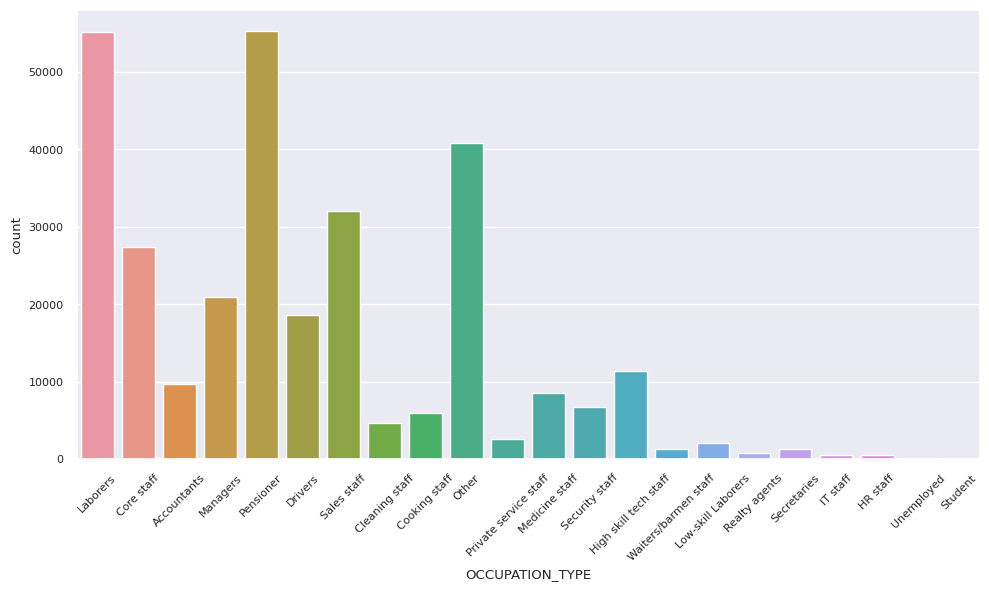

In [561]:
plt.figure(figsize=(10,6))
sns.countplot(x="OCCUPATION_TYPE", data=app)
# smaller font size for xticks and yticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(rotation=45)
# space between plots
plt.tight_layout()

### CNT_FAM_MEMBERS

In [562]:
app.CNT_FAM_MEMBERS.value_counts(dropna=False)

2.0    157746
1.0     67657
3.0     52407
4.0     24594
5.0      3461
6.0       406
7.0        81
8.0        19
NaN         2
Name: CNT_FAM_MEMBERS, dtype: int64

<Axes: >

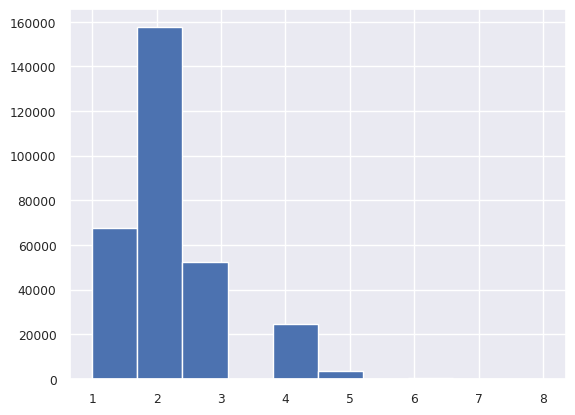

In [563]:
app.CNT_FAM_MEMBERS.hist()

### REGION_RATING_CLIENT

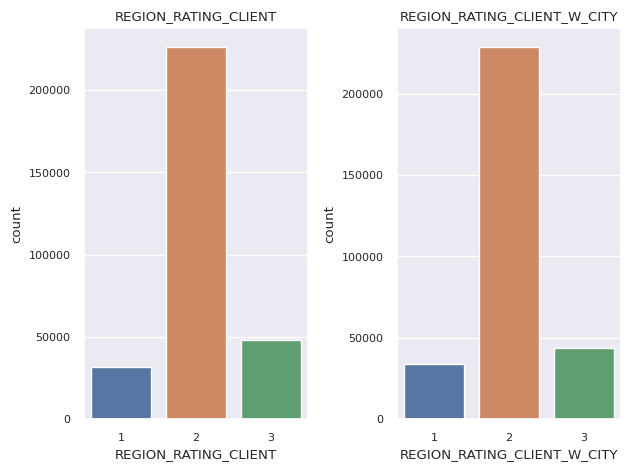

In [564]:
for i, col in enumerate(app.filter(regex='REGION_RATING_CLIENT*').columns):
    ax = plt.subplot(1, 2, i+1)
    sns.countplot(x=col, data=app, ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

### WEEKDAY_APPR_PROCESS_START

<Axes: xlabel='WEEKDAY_APPR_PROCESS_START', ylabel='count'>

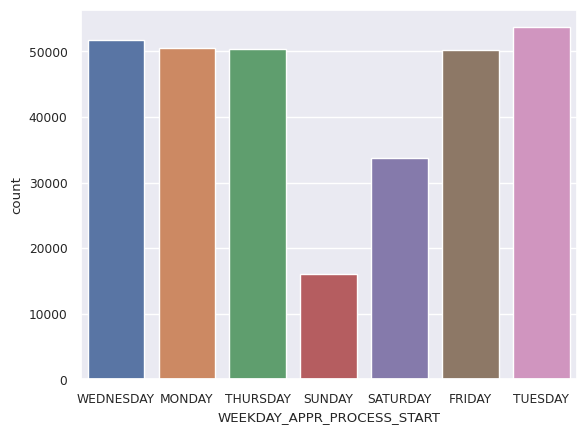

In [565]:
# Interesting distribution. This implies that most applications happen during business day (with very even distribution)
sns.countplot(x='WEEKDAY_APPR_PROCESS_START', data=app)

### HOUR_APPR_PROCESS_START

<Axes: >

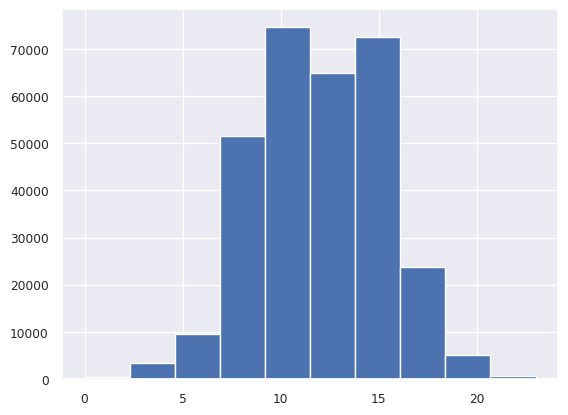

In [566]:
# Interesting distribution, we can clearly see the major working hour is around 8 AM to 5 PM
# This implies that most applications happen during business hour
app.HOUR_APPR_PROCESS_START.hist()

### Columns for "Flag if there is client's address discrepancy"

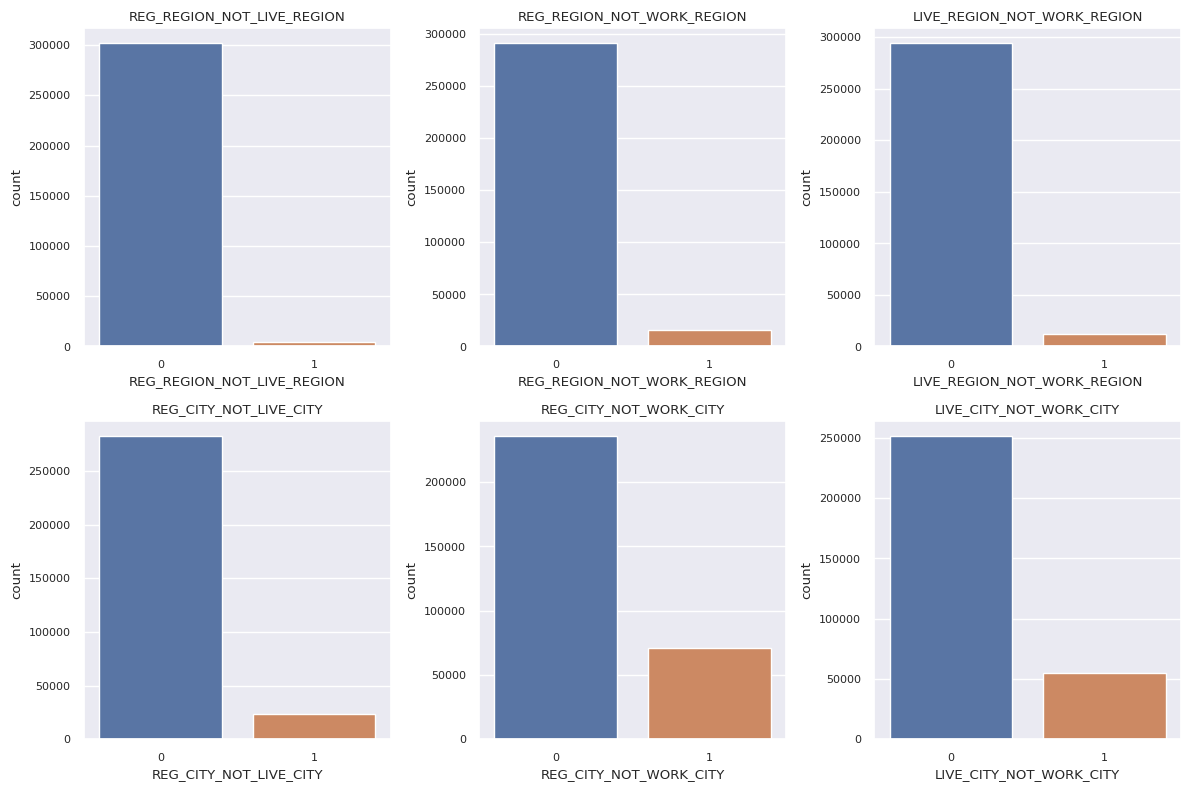

In [567]:
plt.figure(figsize=(12,8))

for i, col in enumerate([
        "REG_REGION_NOT_LIVE_REGION",
        "REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION",
        "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY",
        "LIVE_CITY_NOT_WORK_CITY",
    ]
):
    ax = plt.subplot(2, 3, i+1)
    sns.countplot(x=col, data=app, ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

### ORGANIZATION_TYPE - n

In [568]:
app.ORGANIZATION_TYPE.value_counts()

Business Entity Type 3    67625
XNA                       55280
Self-employed             38298
Other                     16611
Medicine                  11157
Business Entity Type 2    10520
Government                10378
School                     8876
Trade: type 7              7799
Kindergarten               6873
Construction               6690
Business Entity Type 1     5942
Transport: type 4          5380
Trade: type 3              3479
Industry: type 9           3351
Industry: type 3           3275
Security                   3236
Housing                    2952
Industry: type 11          2693
Military                   2617
Bank                       2477
Agriculture                2452
Police                     2328
Transport: type 2          2198
Postal                     2153
Security Ministries        1958
Trade: type 2              1887
Restaurant                 1807
Services                   1569
University                 1318
Industry: type 7           1303
Transpor

**Observation**: We notice 55374 is the number of pensioner. We assume that 'XNA' values is for this

In [569]:
# we notice 55374 is the number of pensioner
# rename organization type to pensioner
app.ORGANIZATION_TYPE.replace('XNA', 'Pensioner', inplace=True)

### EXT_SOURCE_* - n

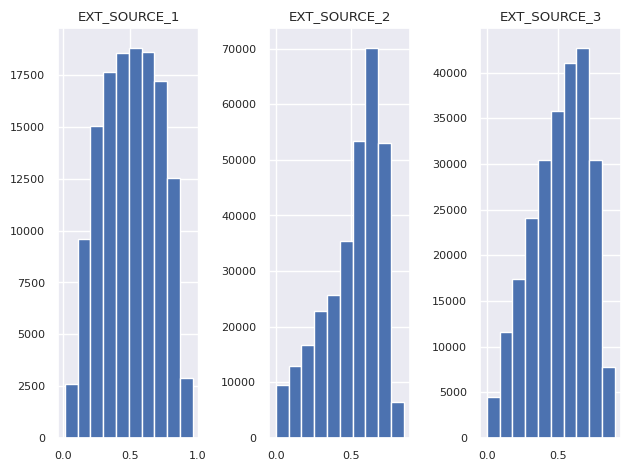

In [570]:
# Column definition: Normalized score from external data source
# This seems to be very important

# plt.figure(figsize=(12,8))

for i, col in enumerate(app.filter(regex='EXT_SOURCE_*').columns):
    ax = plt.subplot(1, 3, i+1)
    app[col].hist(ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

In [571]:
for i, col in enumerate(app.filter(regex='EXT_SOURCE_*').columns):
  print(f"Missing values in {col}: {app[col].isnull().sum()}")

Missing values in EXT_SOURCE_1: 172791
Missing values in EXT_SOURCE_2: 660
Missing values in EXT_SOURCE_3: 60710


**Observation**: They are MCAR in nature due to being originating from external data sources. Despite this, their distributions are very interesting so we should keep this.

**Work around - Feature Engineer**: To handle this, we create another flag attributes to indicate their missingness.

In [572]:
# let's create another column to flag the missingness
app['EXT_SOURCE_1_MISSING'] = app['EXT_SOURCE_1'].isnull().astype(int)
app['EXT_SOURCE_1_MISSING'].value_counts()

1    172791
0    133582
Name: EXT_SOURCE_1_MISSING, dtype: int64

In [573]:
# let's create another column to flag the missingness
app['EXT_SOURCE_2_MISSING'] = app['EXT_SOURCE_2'].isnull().astype(int)
app['EXT_SOURCE_2_MISSING'].value_counts()

0    305713
1       660
Name: EXT_SOURCE_2_MISSING, dtype: int64

In [574]:
# let's create another column to flag the missingness
app['EXT_SOURCE_3_MISSING'] = app['EXT_SOURCE_3'].isnull().astype(int)
app['EXT_SOURCE_3_MISSING'].value_counts()

0    245663
1     60710
Name: EXT_SOURCE_3_MISSING, dtype: int64

### Columns for "Normalized information about building where the client lives"

In [575]:
# Columns for "Normalized information about building where the client lives"
building_info = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "TOTALAREA_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE",
]

In [576]:
app[building_info].isnull().sum()

APARTMENTS_AVG                  155684
BASEMENTAREA_AVG                179477
YEARS_BEGINEXPLUATATION_AVG     149646
YEARS_BUILD_AVG                 203910
COMMONAREA_AVG                  214227
ELEVATORS_AVG                   163487
ENTRANCES_AVG                   154459
FLOORSMAX_AVG                   152653
FLOORSMIN_AVG                   208027
LANDAREA_AVG                    182076
LIVINGAPARTMENTS_AVG            209577
LIVINGAREA_AVG                  153973
NONLIVINGAPARTMENTS_AVG         212880
NONLIVINGAREA_AVG               169247
APARTMENTS_MODE                 155684
BASEMENTAREA_MODE               179477
YEARS_BEGINEXPLUATATION_MODE    149646
YEARS_BUILD_MODE                203910
COMMONAREA_MODE                 214227
ELEVATORS_MODE                  163487
ENTRANCES_MODE                  154459
FLOORSMAX_MODE                  152653
FLOORSMIN_MODE                  208027
LANDAREA_MODE                   182076
LIVINGAPARTMENTS_MODE           209577
LIVINGAREA_MODE          

**Observation**: They seem to be MCAR. Due to the sheer number of missing values, we shall drop these columns

In [577]:
app = app.drop(building_info, axis=1)

### *_CNT_SOCIAL_CIRCLE - o

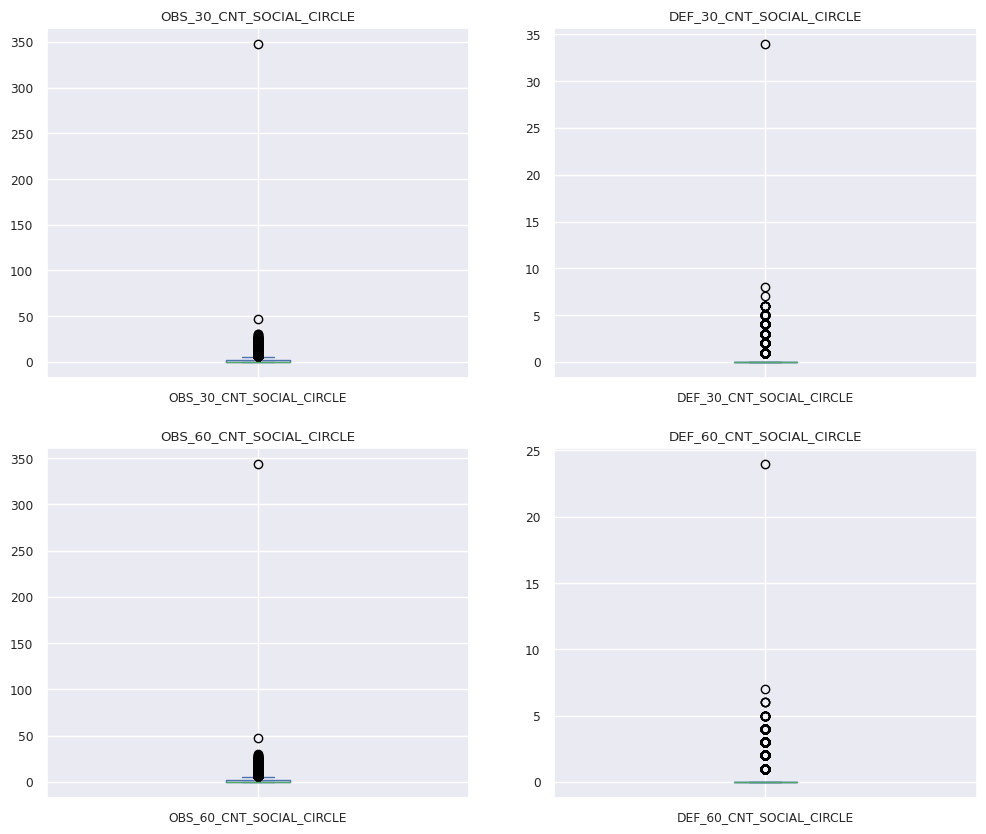

In [578]:
# iterate over OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, and DEF_60_CNT_SOCIAL_CIRCLE, print out boxplot and 99.99 percentile
# plot using plt
plt.figure(figsize=(12,10))

for i, col in enumerate([
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE']):

    ax = plt.subplot(2,2,i+1)
    app[col].plot(kind='box', ax=ax)
    plt.title(col)


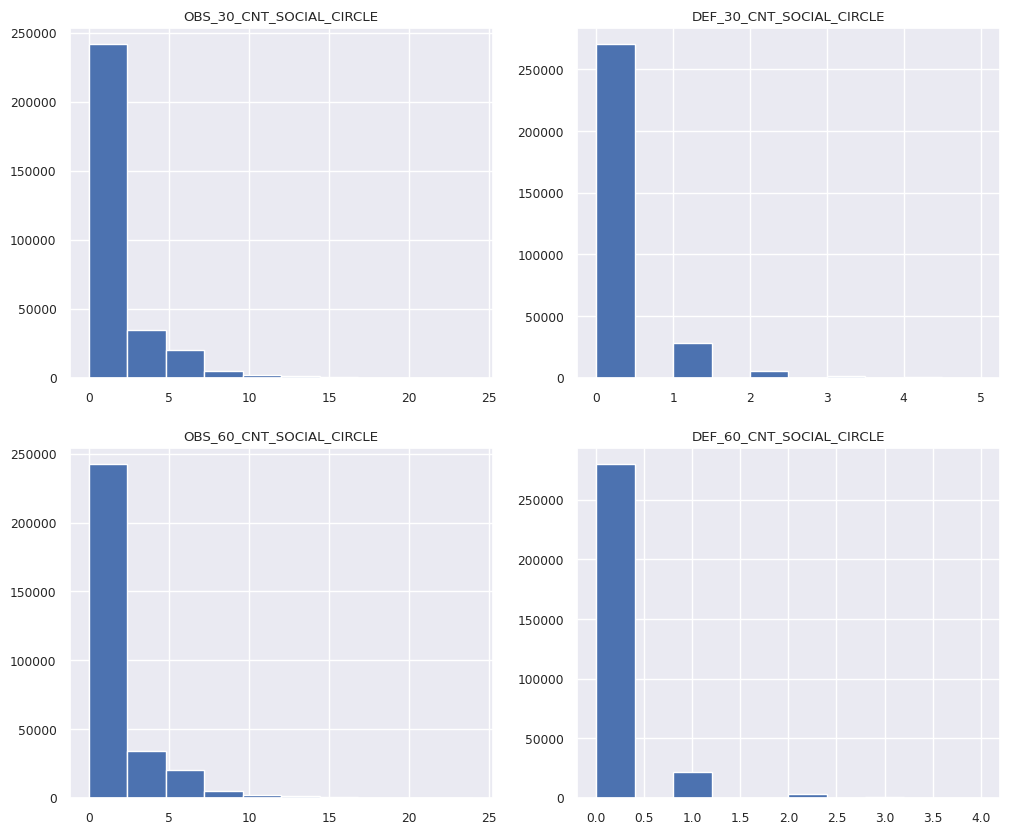

In [579]:
# We can detect outliers that affect our plots
# These outliers are not normal and should be remove
plt.figure(figsize=(12,10))

for i, col in enumerate([
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE']):

    # remove values above the 99.99 percentile (keep null)
    app.loc[app[col] > app[col].quantile(0.9999), col] = np.nan
    # plot histogram
    ax = plt.subplot(2,2,i+1)
    app[col].hist(ax=ax)
    plt.title(col)

### FLAG_DOCUMENT_*

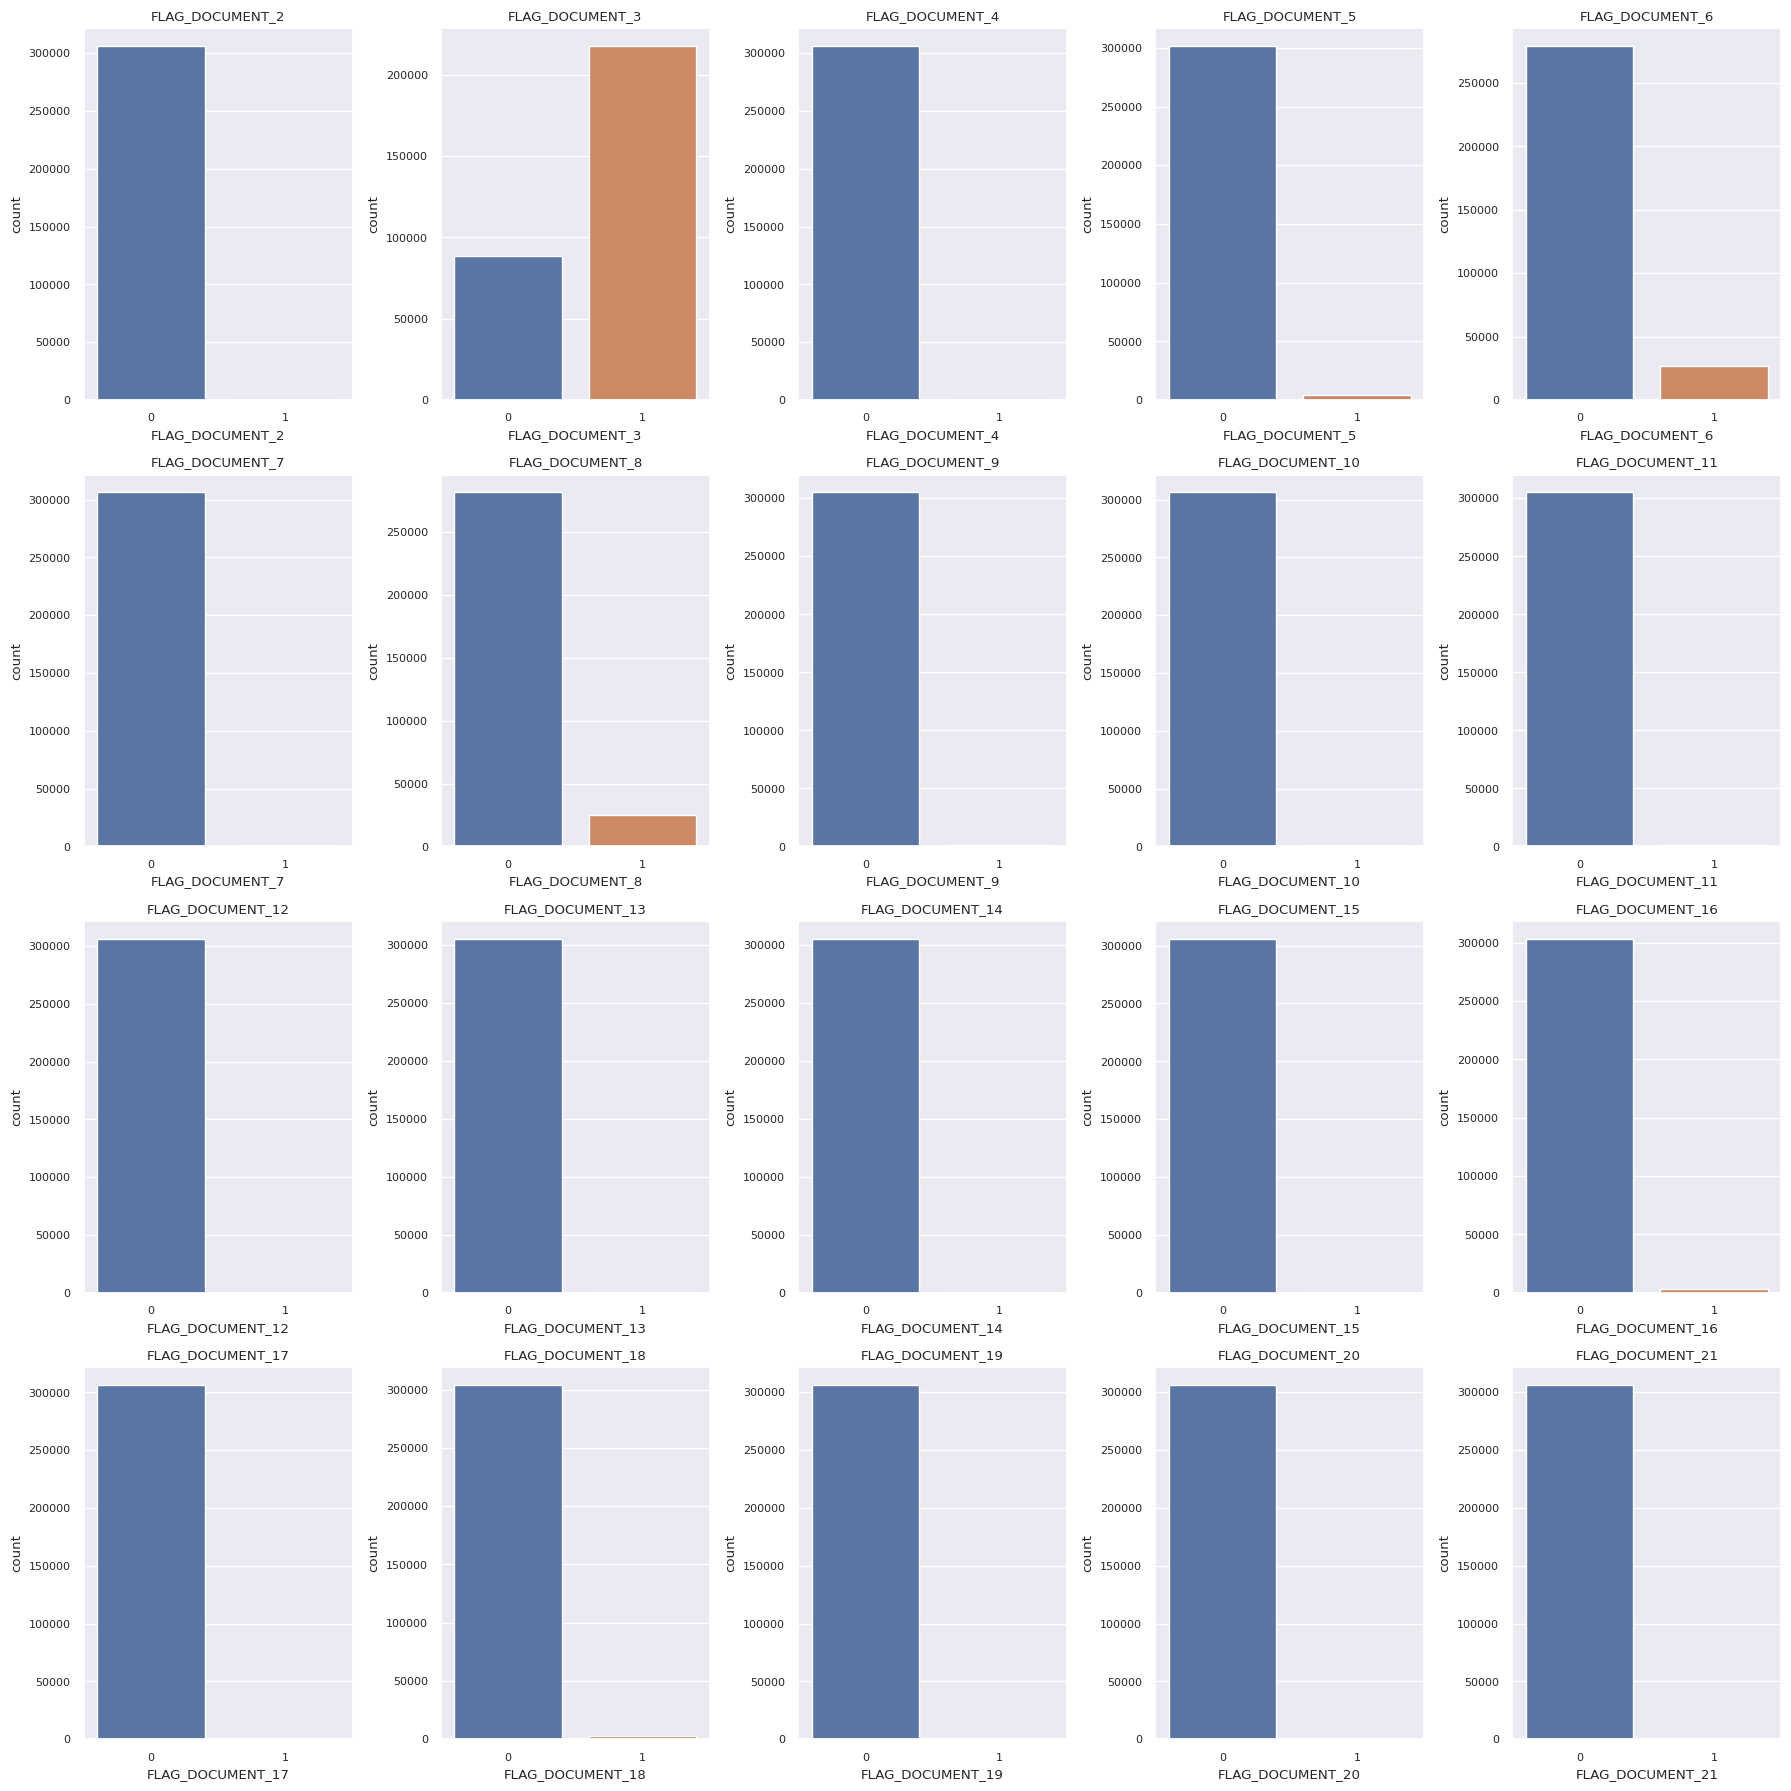

In [580]:
# we notice that FLAG_DOCUMENT_* columns are binary
# iterate through FLAG_DOCUMENT_* columns, plot their distribution
plt.figure(figsize=(18,18))

for i, col in enumerate(app.filter(regex='FLAG_DOCUMENT_*').columns):
    ax = plt.subplot(4,5,i+1)
    sns.countplot(x=col, data=app, ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

**Observation**: A lot of unbalanced features, but there are interesting columns like 3, 6, and 8.

### AMT_REQ_CREDIT_BUREAU_* - o

In [581]:
app.AMT_REQ_CREDIT_BUREAU_HOUR.value_counts(dropna=False)

0.0    263391
NaN     41361
1.0      1555
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

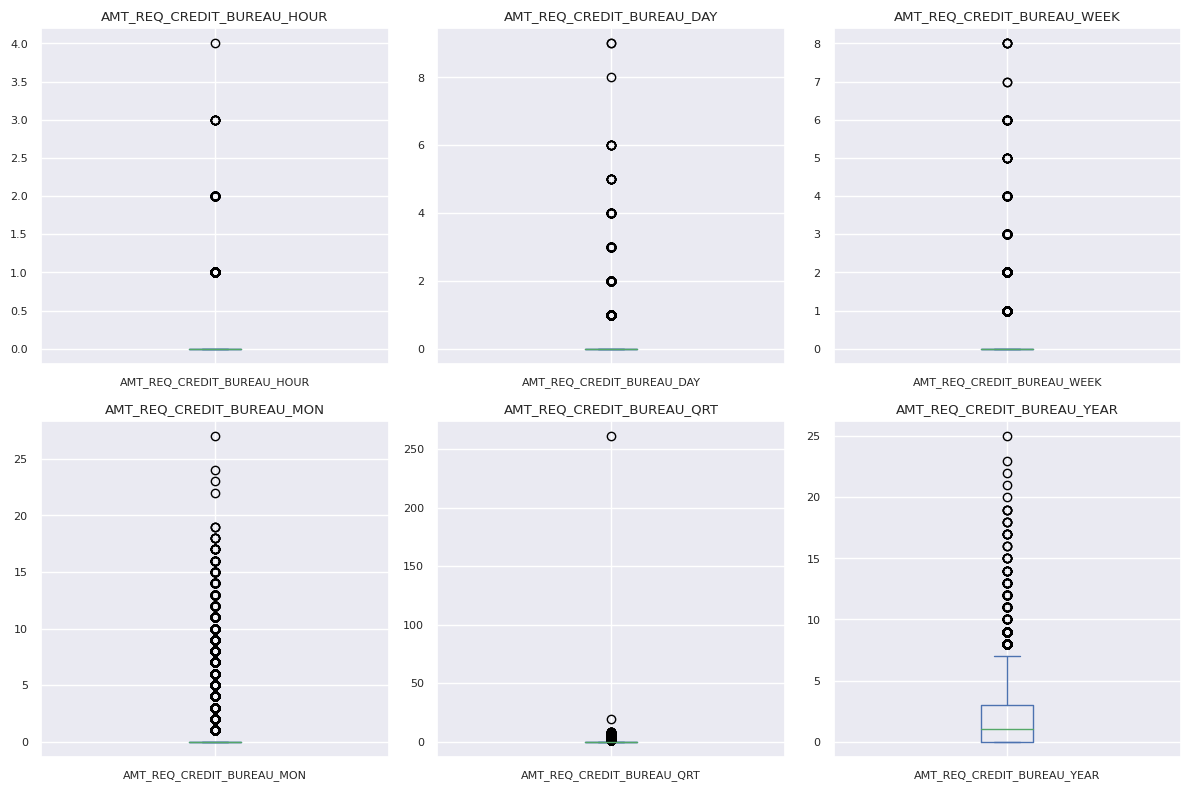

In [582]:
# iterate through AMT_REQ_CREDIT_BUREAU_* columns, plot their distribution
plt.figure(figsize=(12,8))

for i, col in enumerate(app.filter(regex='AMT_REQ_CREDIT_BUREAU_*').columns):
    ax = plt.subplot(2,3,i+1)
    app[col].plot(kind='box', ax=ax)
    # sns.countplot(x=col, data=app, ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

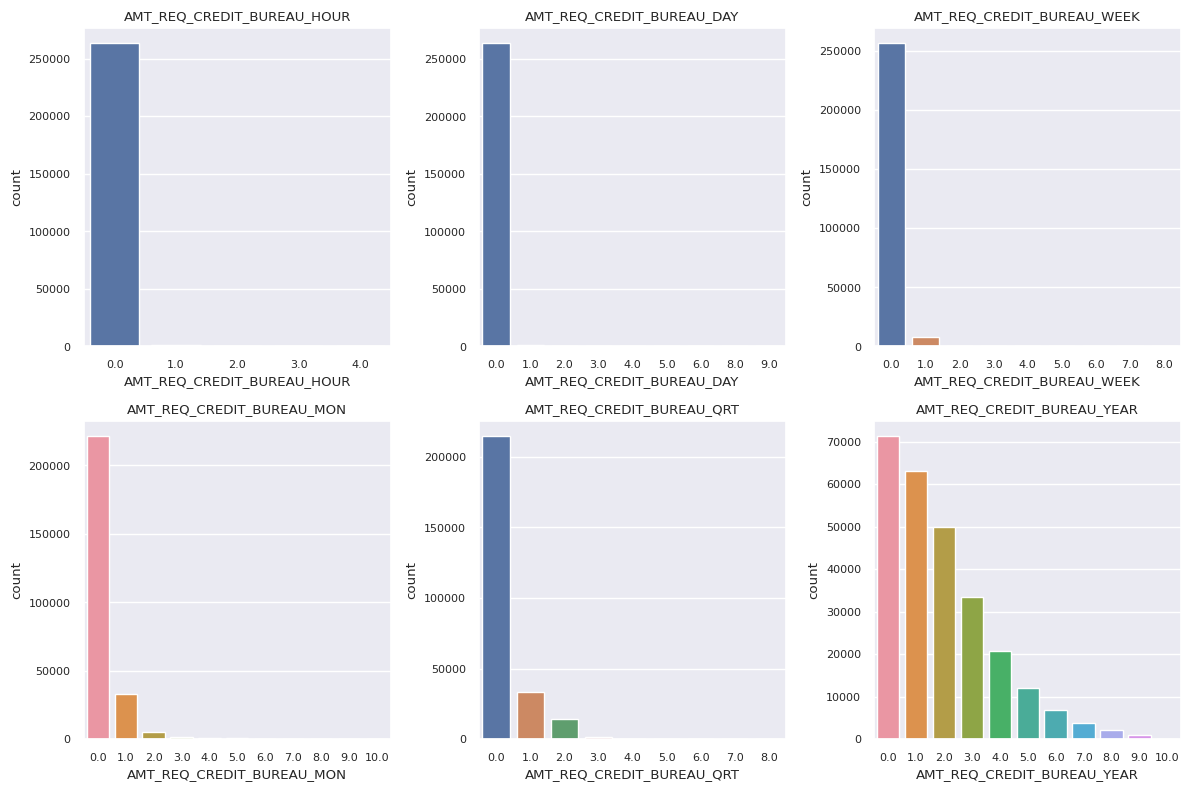

In [583]:
# for AMT_REQ_CREDIT_BUREAU_* columns, outliers means excessive queries which is not normal and requires further investigation
# remove outliers, or values > 10
AMT_REQ_CREDIT_BUREAU_THRESHOLD = 10

plt.figure(figsize=(12,8))

for i, col in enumerate(app.filter(regex='AMT_REQ_CREDIT_BUREAU_*').columns):
    ax = plt.subplot(2,3,i+1)
    # drop rows of outliers (keep existing null rows)
    app[col].where(app[col] <= AMT_REQ_CREDIT_BUREAU_THRESHOLD, inplace=True)
    sns.countplot(x=col, data=app, ax=ax)
    # smaller font size for xticks and yticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # space between plots
    plt.tight_layout()
    plt.title(col)

## Feature engineering - `app` DataFrame

### NAME_EDUCATION_TYPE

In [584]:
app.NAME_EDUCATION_TYPE.value_counts(dropna=False)

Secondary / secondary special    218038
Higher education                  74119
Incomplete higher                 10245
Lower secondary                    3809
Academic degree                     162
Name: NAME_EDUCATION_TYPE, dtype: int64

**Observation**: the categories have a clear ordinal relationship

In [585]:
education_order = {
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}

# Create a new feature with encoded values
app['ENG_NAME_EDUCATION_TYPE_ENCODED'] = app['NAME_EDUCATION_TYPE'].map(education_order)

### DAYS_BIRTH

**Observation**: We can convert the DAYS_BIRTH attribute into ages

In [586]:
app['ENG_AGE_INT'] = app['DAYS_BIRTH'] // -365

### DAYS_EMPLOYED

**Observation**: DAYS_EMPLOYED uses a special value `365243` to indicate "Retirement" for a column full of negative integers. We should make a new attribute to indicate if someone is retired to make the data more explicit for the model.

In [587]:
app['ENG_RETIRED_FLAG'] = (app['DAYS_EMPLOYED'] == 365243).astype(int).value_counts()

### Relationship between credits and other amount

In [588]:
# credit/annuity ratio
app['ENG_CREDIT_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']
# credit/income ratio
app['ENG_CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
# annuity/income ratio
app['ENG_ANNUITY_INCOME_RATIO'] = app['AMT_ANNUITY'] / app['AMT_INCOME_TOTAL']
# goods price/credit ratio
app['ENG_GOODS_CREDIT_RATIO'] = app['AMT_GOODS_PRICE'] / app['AMT_CREDIT']
# credit down payment
app['ENG_CREDIT_DOWN_PAYMENT'] = app['AMT_GOODS_PRICE'] - app['AMT_CREDIT']

## Save our cleaned `app` DataFrame

In [589]:
# export app to csv
app.to_csv(f"{DATA_DIR}/application_data_cleaned.csv", index=False)

## EDA & Cleaning - `app_prev` DataFrame

In [590]:
app_prev.isnull().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [591]:
interesting_fields = [
    "NAME_CONTRACT_STATUS",
    "NAME_CONTRACT_TYPE",
    "CODE_REJECT_REASON",
    "PRODUCT_COMBINATION",
    "NAME_SELLER_INDUSTRY",
    "AMT_ANNUITY",
    "AMT_APPLICATION",
    "AMT_CREDIT",
    "AMT_DOWN_PAYMENT",
    "AMT_GOODS_PRICE",
    "CNT_PAYMENT",]

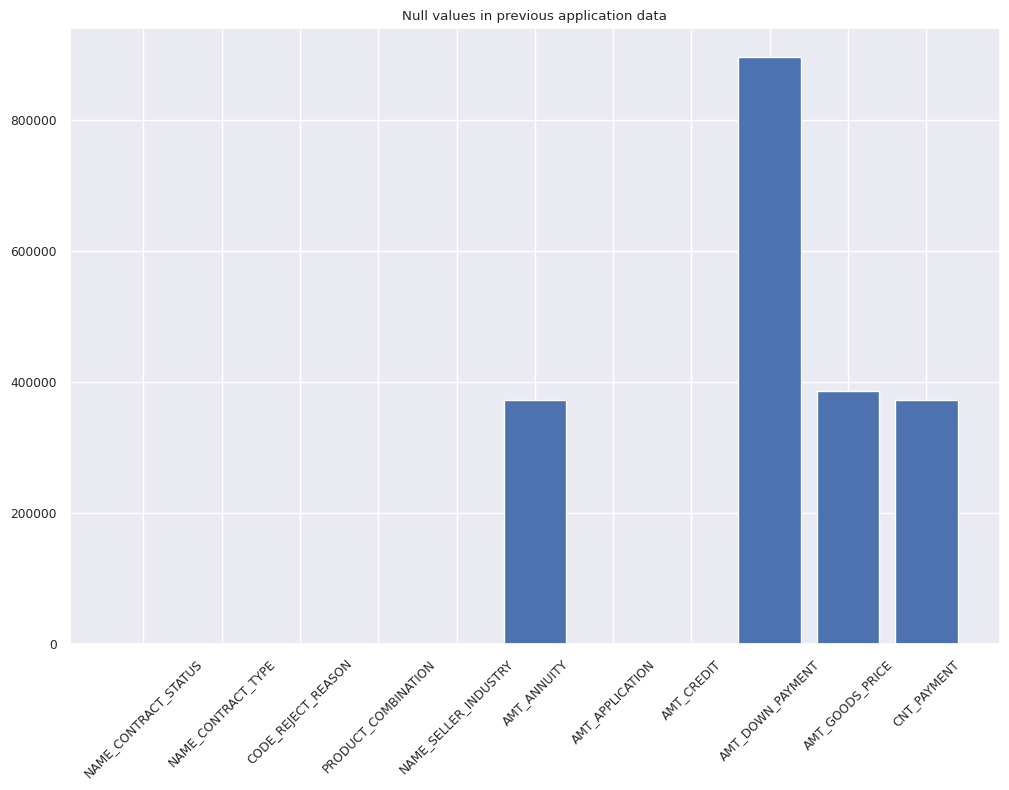

In [592]:
# create a dict, for each field, the value is the number of null values
null_values = {}
for field in interesting_fields:
    null_values[field] = app_prev[field].isnull().sum()
# plot null values
plt.figure(figsize=(12, 8))
plt.bar(null_values.keys(), null_values.values())
plt.xticks(rotation=45)
plt.title("Null values in previous application data")
plt.show()

In [593]:
# rows with CNT_PAYMENT null and AMT_ANNUITY null
app_prev[app_prev['CNT_PAYMENT'].isnull() & app_prev['AMT_ANNUITY'].isnull()].shape

(372230, 37)

<Axes: title={'center': 'Null values in AMT_ANNUITY'}>

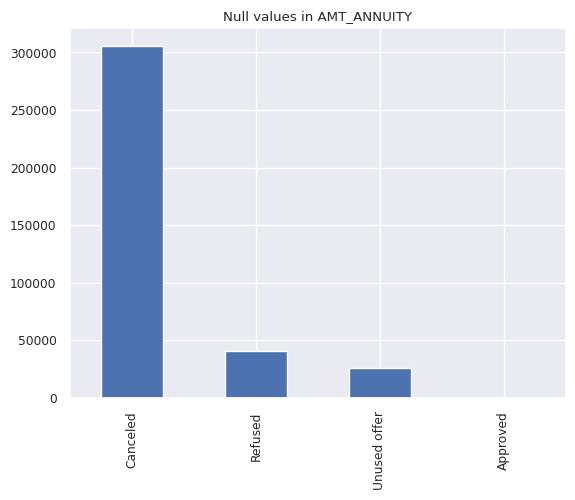

In [594]:
# annuity is null
plt.title("Null values in AMT_ANNUITY")
app_prev[app_prev['AMT_ANNUITY'].isnull()].NAME_CONTRACT_STATUS.value_counts().plot(kind='bar')

In [595]:
# remove when annuity is null but approved
app_prev = app_prev[~((app_prev['AMT_ANNUITY'].isnull()) & (app_prev['NAME_CONTRACT_STATUS'] == 'Approved'))]

In [596]:
# fillna with 0
app_prev['AMT_ANNUITY'] = app_prev['AMT_ANNUITY'].fillna(0)

<Axes: >

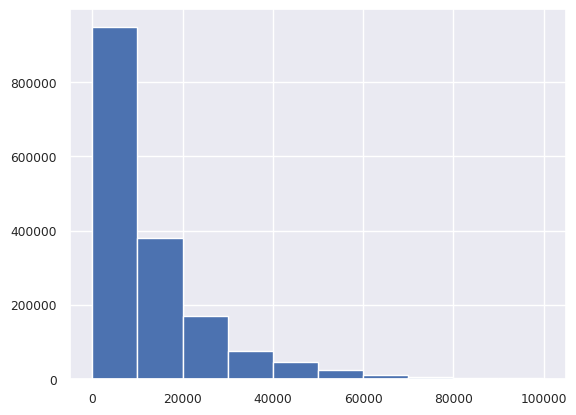

In [597]:
# remove outlier
app_prev = app_prev[app_prev['AMT_ANNUITY'] < 100000]
app_prev.AMT_ANNUITY.hist()

In [598]:
# fillna with 0 for CNT_PAYMENT
app_prev['CNT_PAYMENT'] = app_prev['CNT_PAYMENT'].fillna(0)

<Axes: >

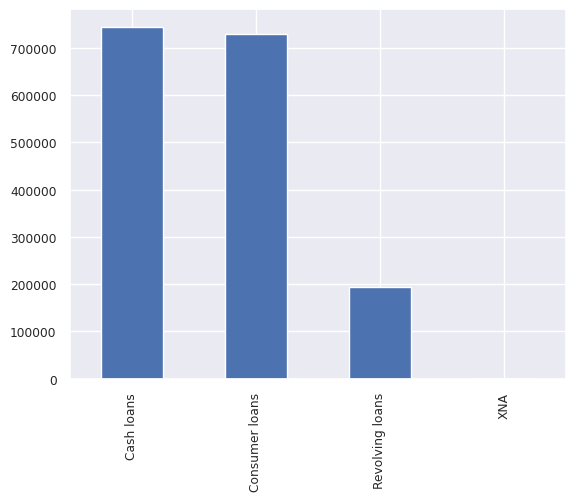

In [599]:
app_prev.NAME_CONTRACT_TYPE.value_counts().plot(kind='bar')

In [600]:
# remove XNA from NAME_CONTRACT_TYPE
app_prev = app_prev[app_prev['NAME_CONTRACT_TYPE'] != 'XNA']

<Axes: >

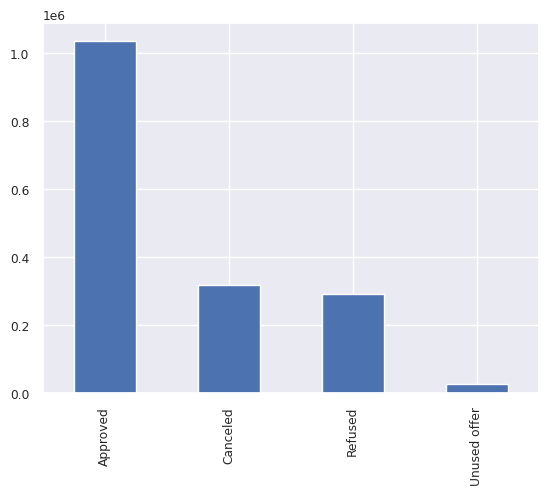

In [601]:
# name contract status
app_prev.NAME_CONTRACT_STATUS.value_counts().plot(kind='bar')

In [602]:
# remove null AMT_CREDIT
app_prev = app_prev[app_prev["AMT_CREDIT"].notnull()]
# remove null PRODUCT_COMBINATION
app_prev = app_prev[app_prev["PRODUCT_COMBINATION"].notnull()]
# drop RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED
app_prev = app_prev.drop(["RATE_INTEREST_PRIMARY",
                          "RATE_INTEREST_PRIVILEGED",
                          "NAME_TYPE_SUITE"], axis=1)


<Axes: title={'center': 'Null values in AMT_DOWN_PAYMENT for each NAME_CONTRACT_TYPE'}>

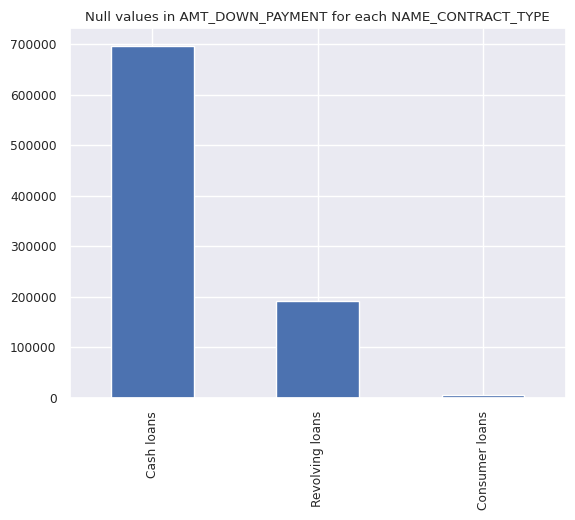

In [603]:
# AMT_DOWN_PAYMENT null when
plt.title("Null values in AMT_DOWN_PAYMENT for each NAME_CONTRACT_TYPE")
app_prev[app_prev['AMT_DOWN_PAYMENT'].isnull()].NAME_CONTRACT_TYPE.value_counts().plot(kind='bar')

<Axes: title={'center': 'AMT_DOWN_PAYMENT missing value percentages and NAME_CONTRACT_TYPE'}, xlabel='NAME_CONTRACT_TYPE'>

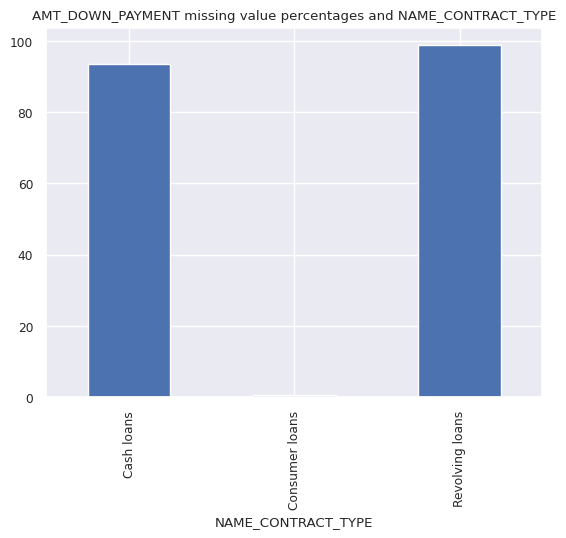

In [604]:
# group by NAME_CONTRACT_TYPE, how much percentages AMT_DOWN_PAYMENT is null
plt.title("AMT_DOWN_PAYMENT missing value percentages and NAME_CONTRACT_TYPE")
app_prev.groupby('NAME_CONTRACT_TYPE')['AMT_DOWN_PAYMENT'].apply(lambda x: x.isnull().sum()/len(x) * 100).plot(kind='bar')

In [605]:
# fillna for AMT_DOWN_PAYMENT when NAME_CONTRACT_TYPE is Revolving loans and Cash loans
app_prev.loc[(app_prev['NAME_CONTRACT_TYPE'] != 'Consumer loans') & (app_prev['AMT_DOWN_PAYMENT'].isnull()), 'AMT_DOWN_PAYMENT'] = 0

In [606]:
app_prev.AMT_DOWN_PAYMENT.isnull().sum()

5109

<Axes: title={'center': 'Null values in AMT_GOODS_PRICE for each NAME_CONTRACT_TYPE'}>

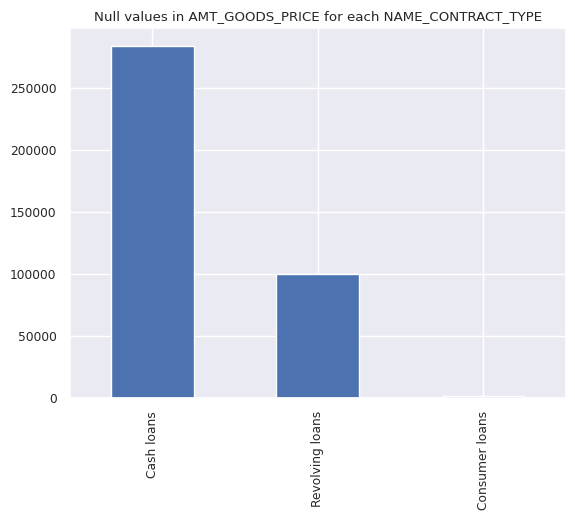

In [607]:
# AMT_GOODS_PRICE null when
plt.title("Null values in AMT_GOODS_PRICE for each NAME_CONTRACT_TYPE")
app_prev[app_prev['AMT_GOODS_PRICE'].isnull()].NAME_CONTRACT_TYPE.value_counts().plot(kind='bar')

<Axes: title={'center': 'AMT_GOODS_PRICE missing value percentages and NAME_CONTRACT_TYPE'}, xlabel='NAME_CONTRACT_TYPE'>

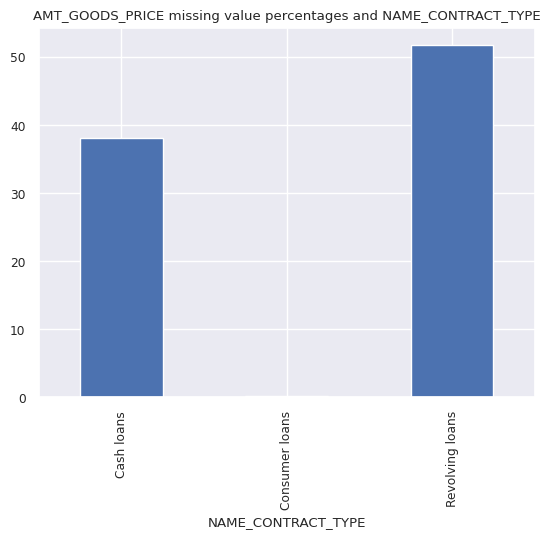

In [608]:
plt.title("AMT_GOODS_PRICE missing value percentages and NAME_CONTRACT_TYPE")
app_prev.groupby('NAME_CONTRACT_TYPE')['AMT_GOODS_PRICE'].apply(lambda x: x.isnull().sum()/len(x) * 100).plot(kind='bar')

In [609]:
# fillna for AMT_DOWN_PAYMENT when NAME_CONTRACT_TYPE is Revolving loans and Cash loans
app_prev.loc[(app_prev['NAME_CONTRACT_TYPE'] != 'Consumer loans') & (app_prev['AMT_DOWN_PAYMENT'].isnull()), 'AMT_GOODS_PRICE'] = 0

## Save our cleaned `app_prev` DataFrame

In [610]:
# export app_prev to csv
app_prev.to_csv(f"{DATA_DIR}/previous_application_cleaned.csv", index=False)

## Feature Engineering & Merging `app` and `app_prev`

In [611]:
app = pd.read_csv(f"{DATA_DIR}/application_data_cleaned.csv")

In [612]:
app_prev = pd.read_csv(f"{DATA_DIR}/previous_application_cleaned.csv")

In [613]:
app_prev_agg = app_prev.groupby("SK_ID_CURR").agg({"SK_ID_PREV": "count"})

interesting_fields_categorical = [
    "NAME_CONTRACT_STATUS",
    "NAME_CONTRACT_TYPE",
    "CODE_REJECT_REASON",
    "PRODUCT_COMBINATION",
    "NAME_SELLER_INDUSTRY"
]

for col in interesting_fields_categorical:
    for name in app_prev[col].unique():
        app_prev_agg["PREV_" + col + "_" + name] = app_prev[app_prev[col] == name].groupby("SK_ID_CURR").agg({"SK_ID_PREV": "count"})

interesting_fields_numerical = [
    "AMT_ANNUITY",
    "AMT_APPLICATION",
    "AMT_CREDIT",
    "AMT_DOWN_PAYMENT",
    "AMT_GOODS_PRICE",
    "CNT_PAYMENT",
]

# aggregate to take min, max, mean, sum, std
for col in interesting_fields_numerical:
    app_prev_agg["PREV_" + col + "_MIN"] = app_prev.groupby("SK_ID_CURR").agg({col: "min"})
    app_prev_agg["PREV_" + col + "_MAX"] = app_prev.groupby("SK_ID_CURR").agg({col: "max"})
    app_prev_agg["PREV_" + col + "_MEAN"] = app_prev.groupby("SK_ID_CURR").agg({col: "mean"})
    app_prev_agg["PREV_" + col + "_SUM"] = app_prev.groupby("SK_ID_CURR").agg({col: "sum"})
    app_prev_agg["PREV_" + col + "_STD"] = app_prev.groupby("SK_ID_CURR").agg({col: "std"})

# create a simple aggregation on SK_ID_CURR, counting SK_ID_PREV, one attribute for each pair (NAME_CONTRACT_STATUS, NAME_CONTRACT_TYPE)
for name1 in app_prev.NAME_CONTRACT_STATUS.unique():
    for name2 in app_prev.NAME_CONTRACT_TYPE.unique():
        app_prev_agg["PREV_" + name1 + "_" + name2] = app_prev[(app_prev["NAME_CONTRACT_STATUS"] == name1) & (app_prev["NAME_CONTRACT_TYPE"] == name2)].groupby("SK_ID_CURR").agg({"SK_ID_PREV": "count"})

# sum of not approved application amount
app_prev_agg["PREV_SUM_AMT_APPLICATION"] = app_prev[app_prev["NAME_CONTRACT_STATUS"] != "Approved"].groupby("SK_ID_CURR").agg({"AMT_APPLICATION": "sum"})

# average of credit over application amount, return 1 if divided by 0
app_prev["CREDIT_OVER_APPLICATION"] = app_prev["AMT_CREDIT"] / app_prev["AMT_APPLICATION"]
# convert all inf to 1
app_prev["CREDIT_OVER_APPLICATION"] = app_prev["CREDIT_OVER_APPLICATION"].fillna(1)
app_prev_agg["PREV_AVG_CREDIT_OVER_APPLICATION"] = app_prev.groupby("SK_ID_CURR").agg({"CREDIT_OVER_APPLICATION": "mean"})
# highest and lowest annuity over credit ratio
app_prev["AMT_ANNUITY_OVER_CREDIT"] = app_prev["AMT_ANNUITY"] / app_prev["AMT_CREDIT"]
app_prev["AMT_ANNUITY_OVER_CREDIT"] = app_prev["AMT_ANNUITY_OVER_CREDIT"].fillna(1)
app_prev_agg["PREV_MAX_ANNUITY_CREDIT_RATIO"] = app_prev.groupby("SK_ID_CURR").agg({"AMT_ANNUITY_OVER_CREDIT": "max"})
app_prev_agg["PREV_MIN_ANNUITY_CREDIT_RATIO"] = app_prev.groupby("SK_ID_CURR").agg({"AMT_ANNUITY_OVER_CREDIT": "min"})


In [614]:
# turn all np.inf in app_prev_agg into 1
app_prev_agg = app_prev_agg.replace([np.inf, -np.inf], 1)
app_prev_agg = app_prev_agg.fillna(0)

In [615]:
# left join the application data to this aggregation
final_df = app.merge(app_prev_agg, how="left", on="SK_ID_CURR").fillna(0)

In [616]:
final_df.shape, app.shape

((306373, 176), (306373, 85))

## Training & Results

In [617]:
# Replace special characters in feature names with underscores
def clean_feature_names(df):
    # Remove special characters and spaces, replace with underscores
    df.columns = [re.sub(r'\W+|_', '_', col) for col in df.columns]
    return df

In [618]:
import re

# one hot encoding final_df
final_df = pd.get_dummies(final_df)

# Apply the function to your DataFrame
final_df = clean_feature_names(final_df)

# convert all "object" dtypes into "categorical" dtypes
for col in final_df.columns:
    if final_df[col].dtype == 'object':
        final_df[col] = final_df[col].astype('category')

In [619]:
# create ensemble model of xgboost and LightGBM
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, VotingClassifier


# split data into X and y
X = final_df.drop(['TARGET'],axis=1)
Y = final_df['TARGET']

# split data into train and test sets
seed = 42
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model no training data
imbalance_ratio = sum(y_train == 0) / sum(y_train == 1)
model2 = lgb.LGBMClassifier(scale_pos_weight=imbalance_ratio, subsample=0.8, colsample_bytree=0.8, random_state=seed)
model1 = XGBClassifier(scale_pos_weight=imbalance_ratio, subsample=0.8, colsample_bytree=0.8, enable_categorical=True, random_state=seed)
# VotingClassifier with soft voting
model = VotingClassifier(estimators=[('xgb', model1), ('lgb', model2)], voting='soft')
model.fit(X_train, y_train)

# evaluate predictions
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))


[LightGBM] [Info] Number of positive: 21099, number of negative: 239318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14324
[LightGBM] [Info] Number of data points in the train set: 260417, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081020 -> initscore=-2.428568
[LightGBM] [Info] Start training from score -2.428568
Accuracy: 73.41%
ROC AUC: 70.03%


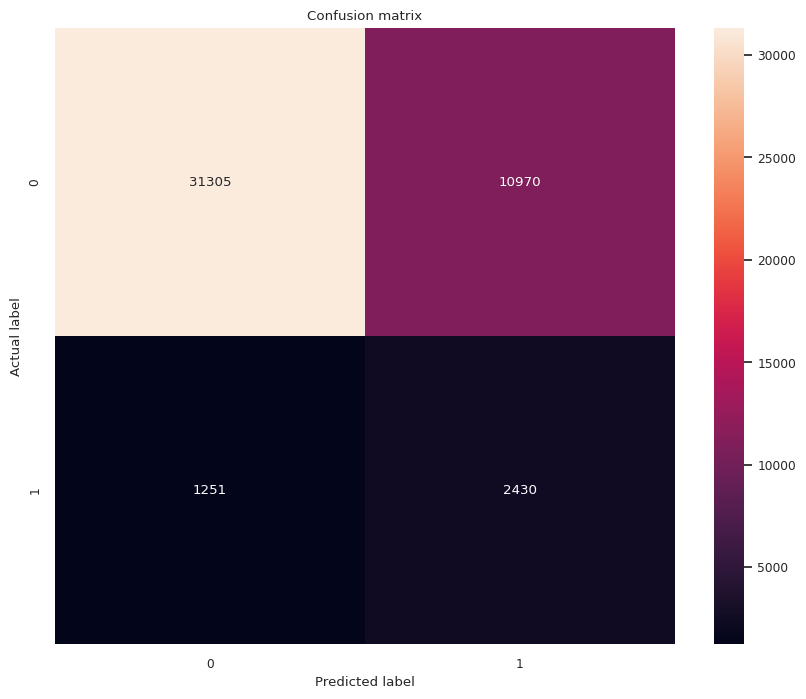

In [620]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

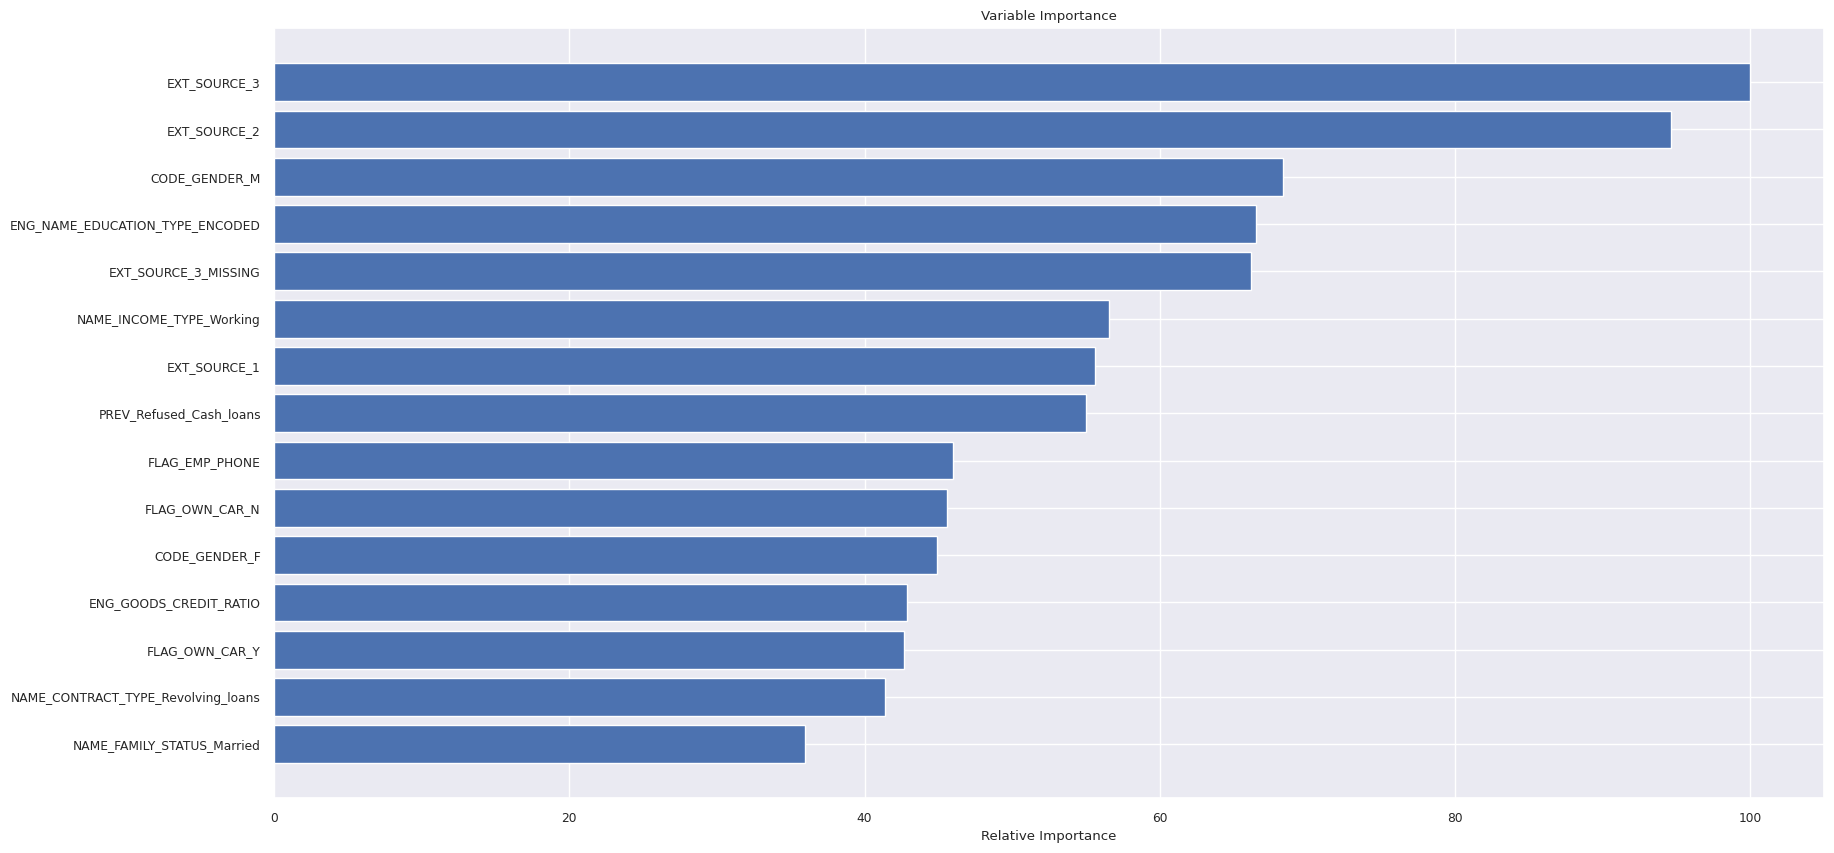

In [621]:
feature_importance = model.estimators_[0].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Additional EDA

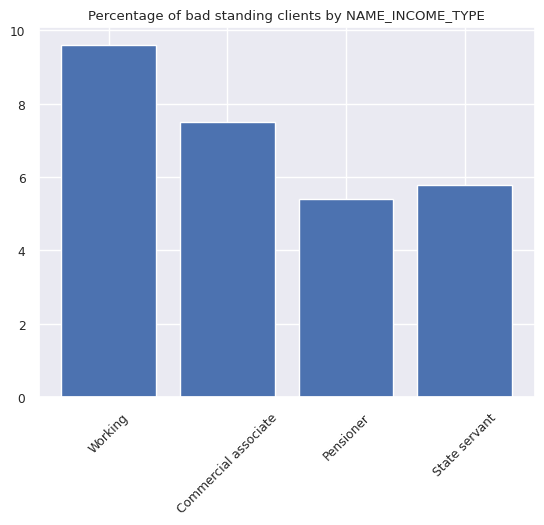

In [622]:
# TARGET IS WHETHER CLIENT IS IN BAD STANDING
# for each type of NAME_INCOME_TYPE, percentage of bad standing clients
prop = {}
for val in ["Working", "Commercial associate", "Pensioner", "State servant"]:
    prop[val] = app[app.NAME_INCOME_TYPE == val].TARGET.sum() / len(app[app.NAME_INCOME_TYPE == val]) * 100

# plot prop
plt.bar(prop.keys(), prop.values())
plt.xticks(rotation=45)
plt.title("Percentage of bad standing clients by NAME_INCOME_TYPE")
plt.show()


In [623]:
df = pd.read_csv(f'{DATA_DIR}/application_data_cleaned.csv')

# 计算income和credit的相关性
income_credit_corr = df['AMT_INCOME_TOTAL'].corr(df['AMT_CREDIT'])
# 计算goods price和credit的相关性
goods_credit_corr = df['AMT_GOODS_PRICE'].corr(df['AMT_CREDIT'])
# 计算annuity和credit的相关性
annuity_corr = df['AMT_ANNUITY'].corr(df['AMT_CREDIT'])
# 如果你要计算其他的相关性，你就按照这个格式去写. column1和column2是你要计算的两个列的名字
# print(df['column1'].corr(df['column2']))

print("Income and Credit Correlation: ", income_credit_corr)
print("Goods Price and Credit Correlation: ", goods_credit_corr)
print("Annuity and Credit Correlation: ", annuity_corr)

Income and Credit Correlation:  0.3903812592663172
Goods Price and Credit Correlation:  0.9862508380445539
Annuity and Credit Correlation:  0.7747416865318815


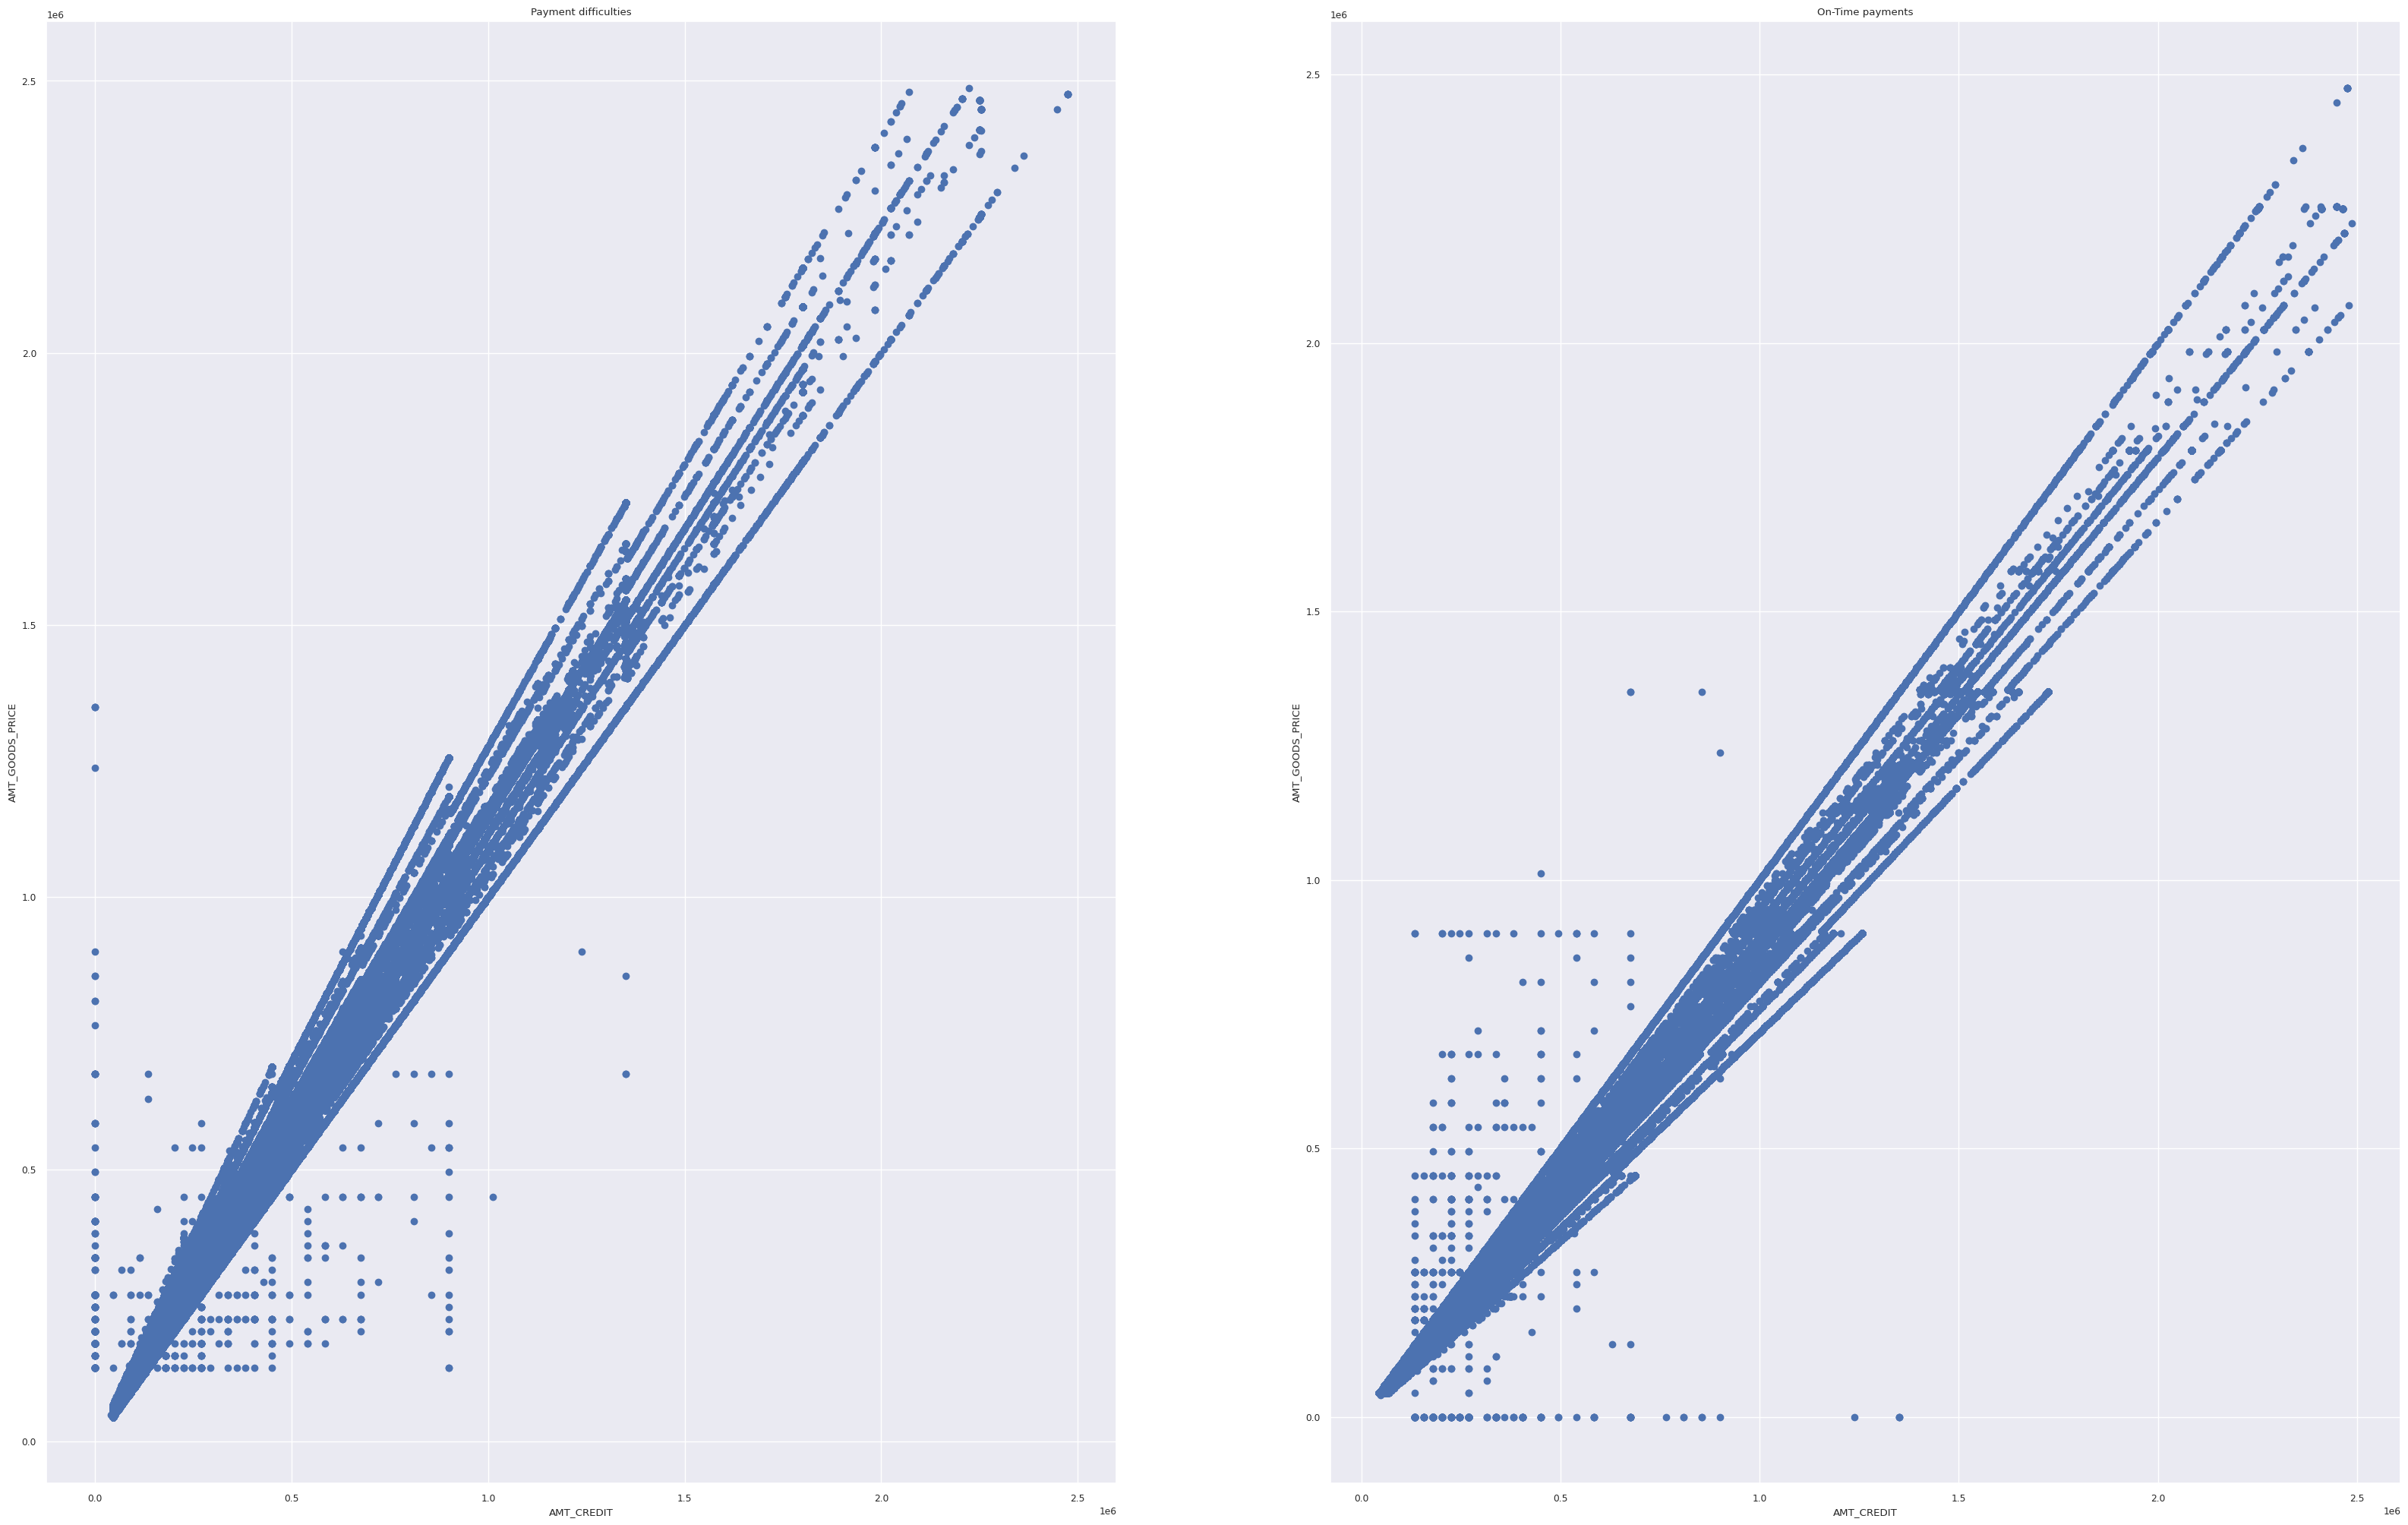

In [624]:
# 创建一个新的figure
# figsize是figure的大小，单位是inch, 你随便改改看看
fig, axs = plt.subplots(1, 2, figsize=(40, 25))

# 创建第一个散点图
# 我不知道你要的是什么关系
# 你有需要自己该参数. AMT_CREDIT和AMT_GOODS_PRICE你改为你要的
# 这两个图代码都一样, 就是参数你自己填填. 你该引号里的就行
axs[0].scatter(df['AMT_GOODS_PRICE'], df['AMT_CREDIT'])
axs[0].set_title('Payment difficulties')
axs[0].set_xlabel('AMT_CREDIT')
axs[0].set_ylabel('AMT_GOODS_PRICE')

# 创建第二个散点图
axs[1].scatter(df['AMT_CREDIT'], df['AMT_GOODS_PRICE'])
axs[1].set_title('On-Time payments')
axs[1].set_xlabel('AMT_CREDIT')
axs[1].set_ylabel('AMT_GOODS_PRICE')

plt.show()


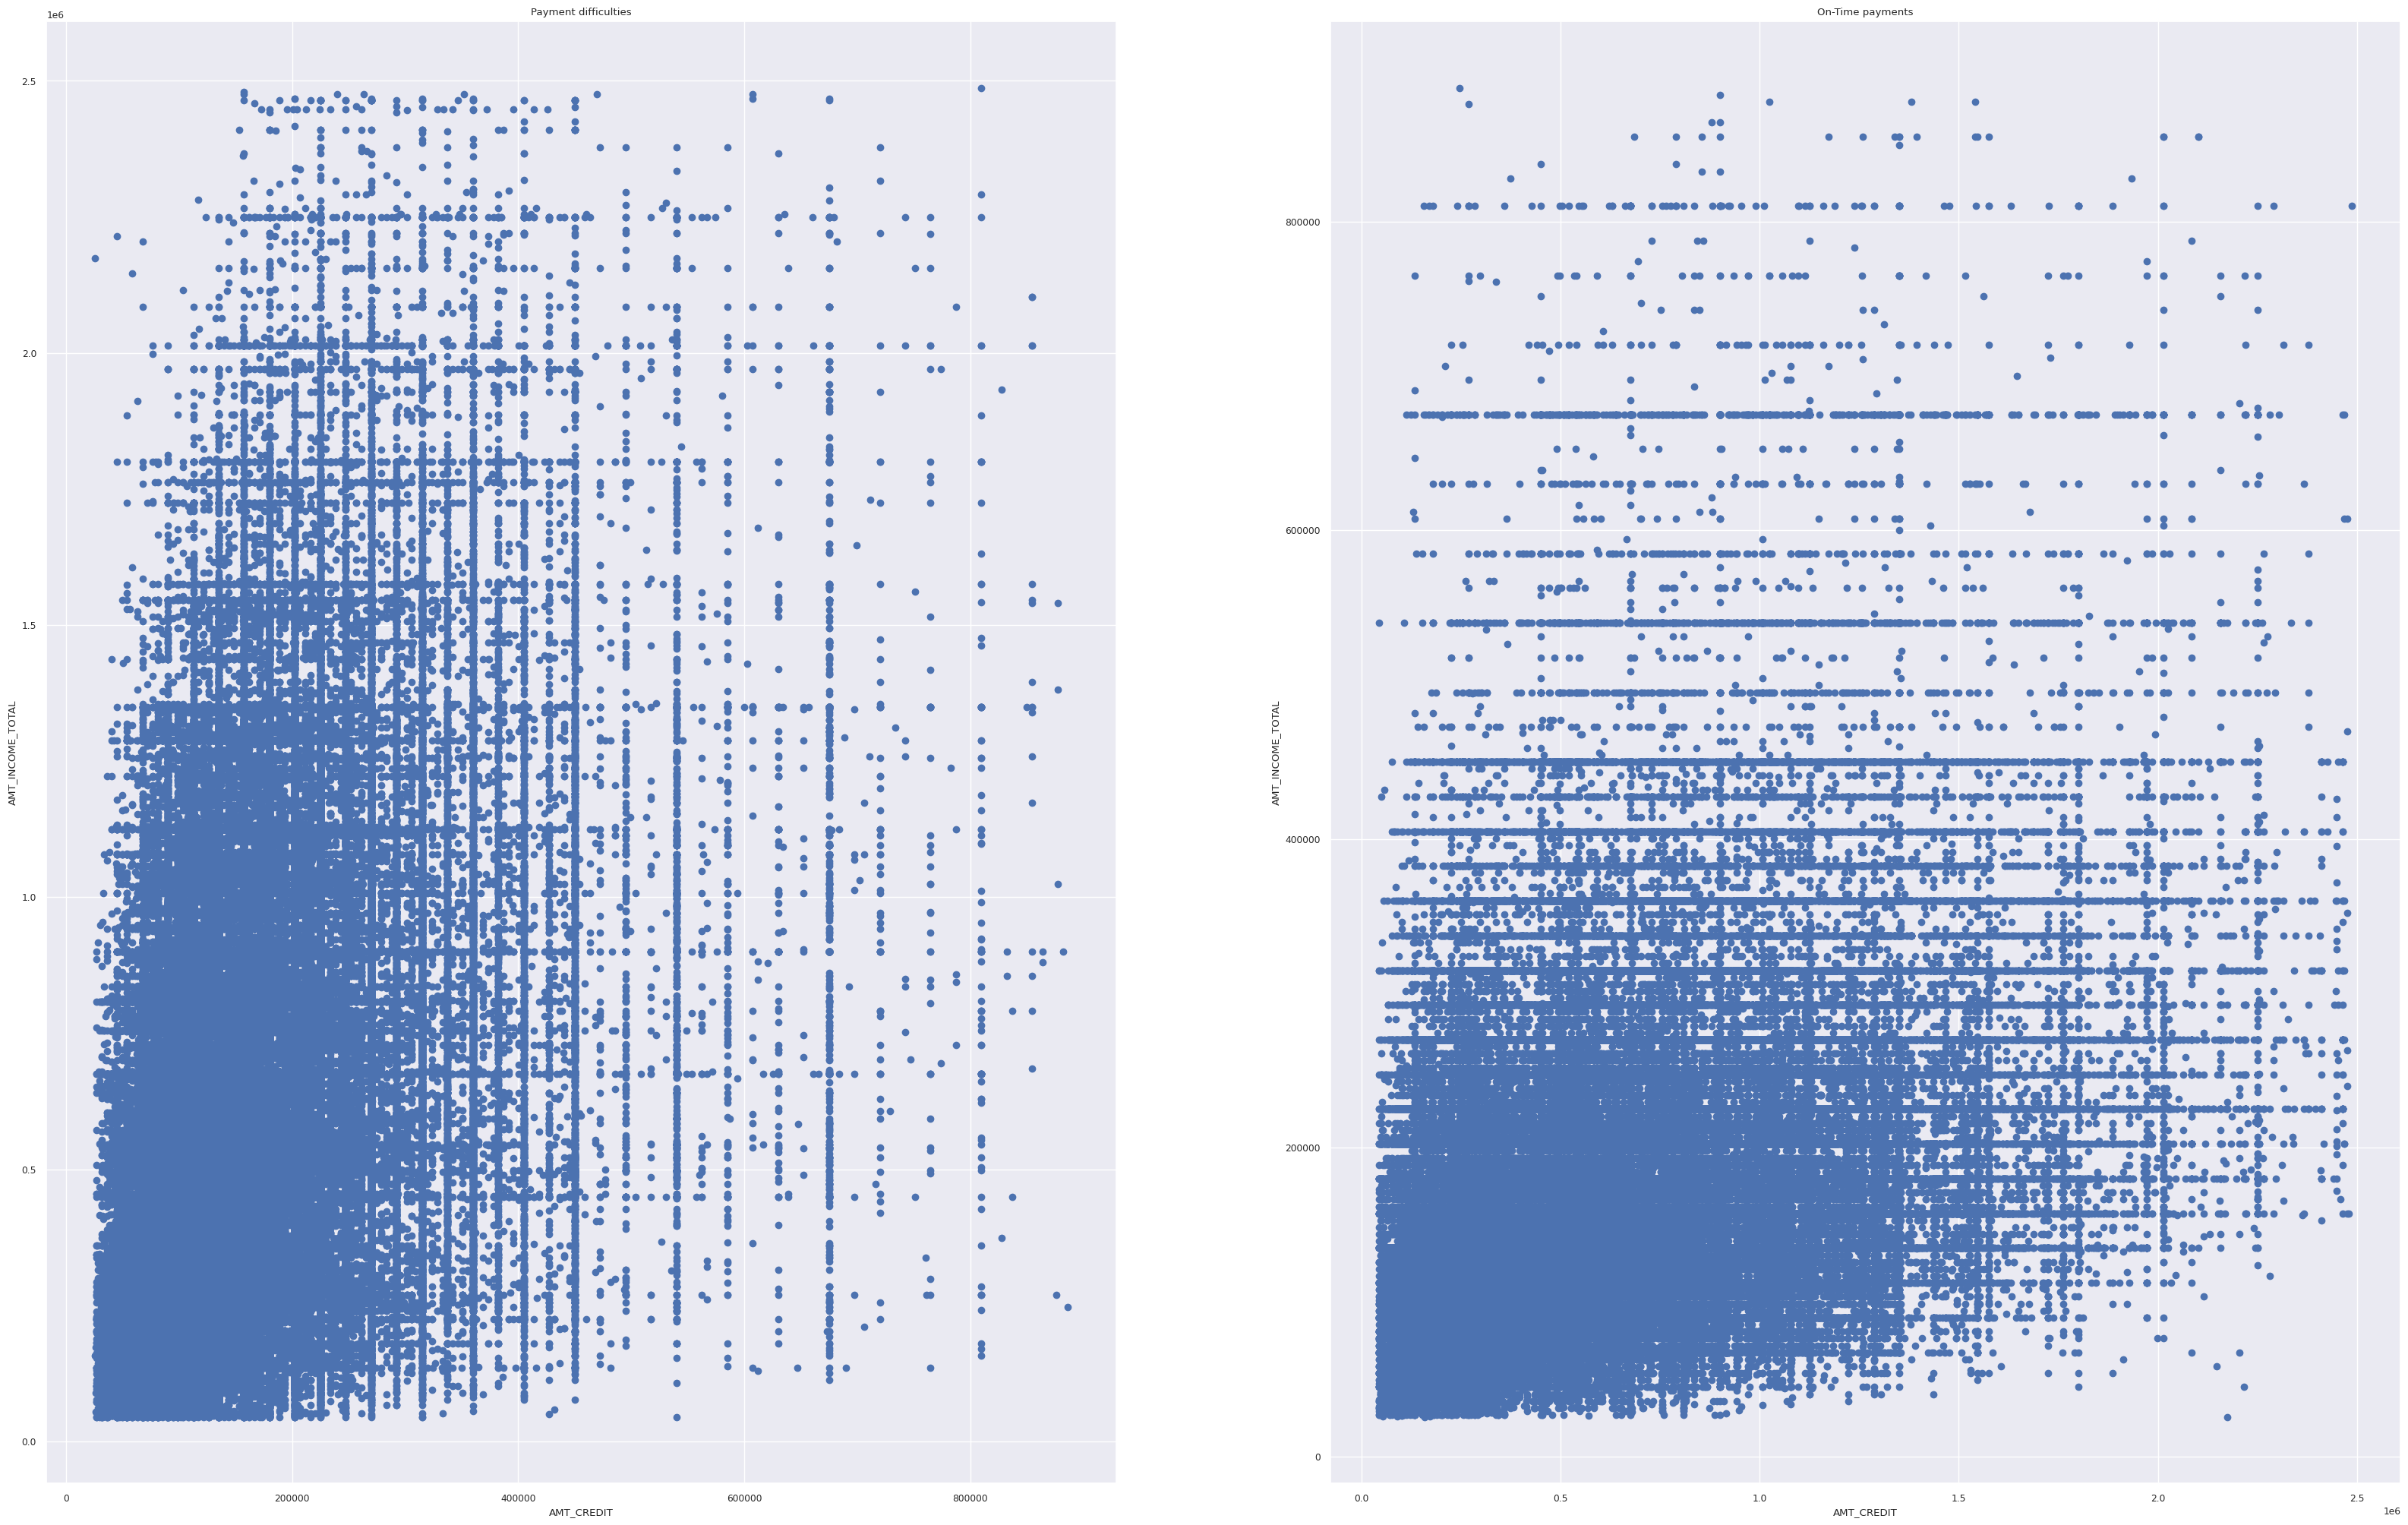

In [625]:
# 创建一个新的figure
# figsize是figure的大小，单位是inch, 你随便改改看看
fig, axs = plt.subplots(1, 2, figsize=(40, 25))

# 创建第一个散点图
# 我不知道你要的是什么关系
# 你有需要自己该参数. AMT_CREDIT和AMT_GOODS_PRICE你改为你要的
# 这两个图代码都一样, 就是参数你自己填填. 你该引号里的就行
axs[0].scatter(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT'])
axs[0].set_title('Payment difficulties')
axs[0].set_xlabel('AMT_CREDIT')
axs[0].set_ylabel('AMT_INCOME_TOTAL')

# 创建第二个散点图
axs[1].scatter(df['AMT_CREDIT'], df['AMT_INCOME_TOTAL'])
axs[1].set_title('On-Time payments')
axs[1].set_xlabel('AMT_CREDIT')
axs[1].set_ylabel('AMT_INCOME_TOTAL')

plt.show()

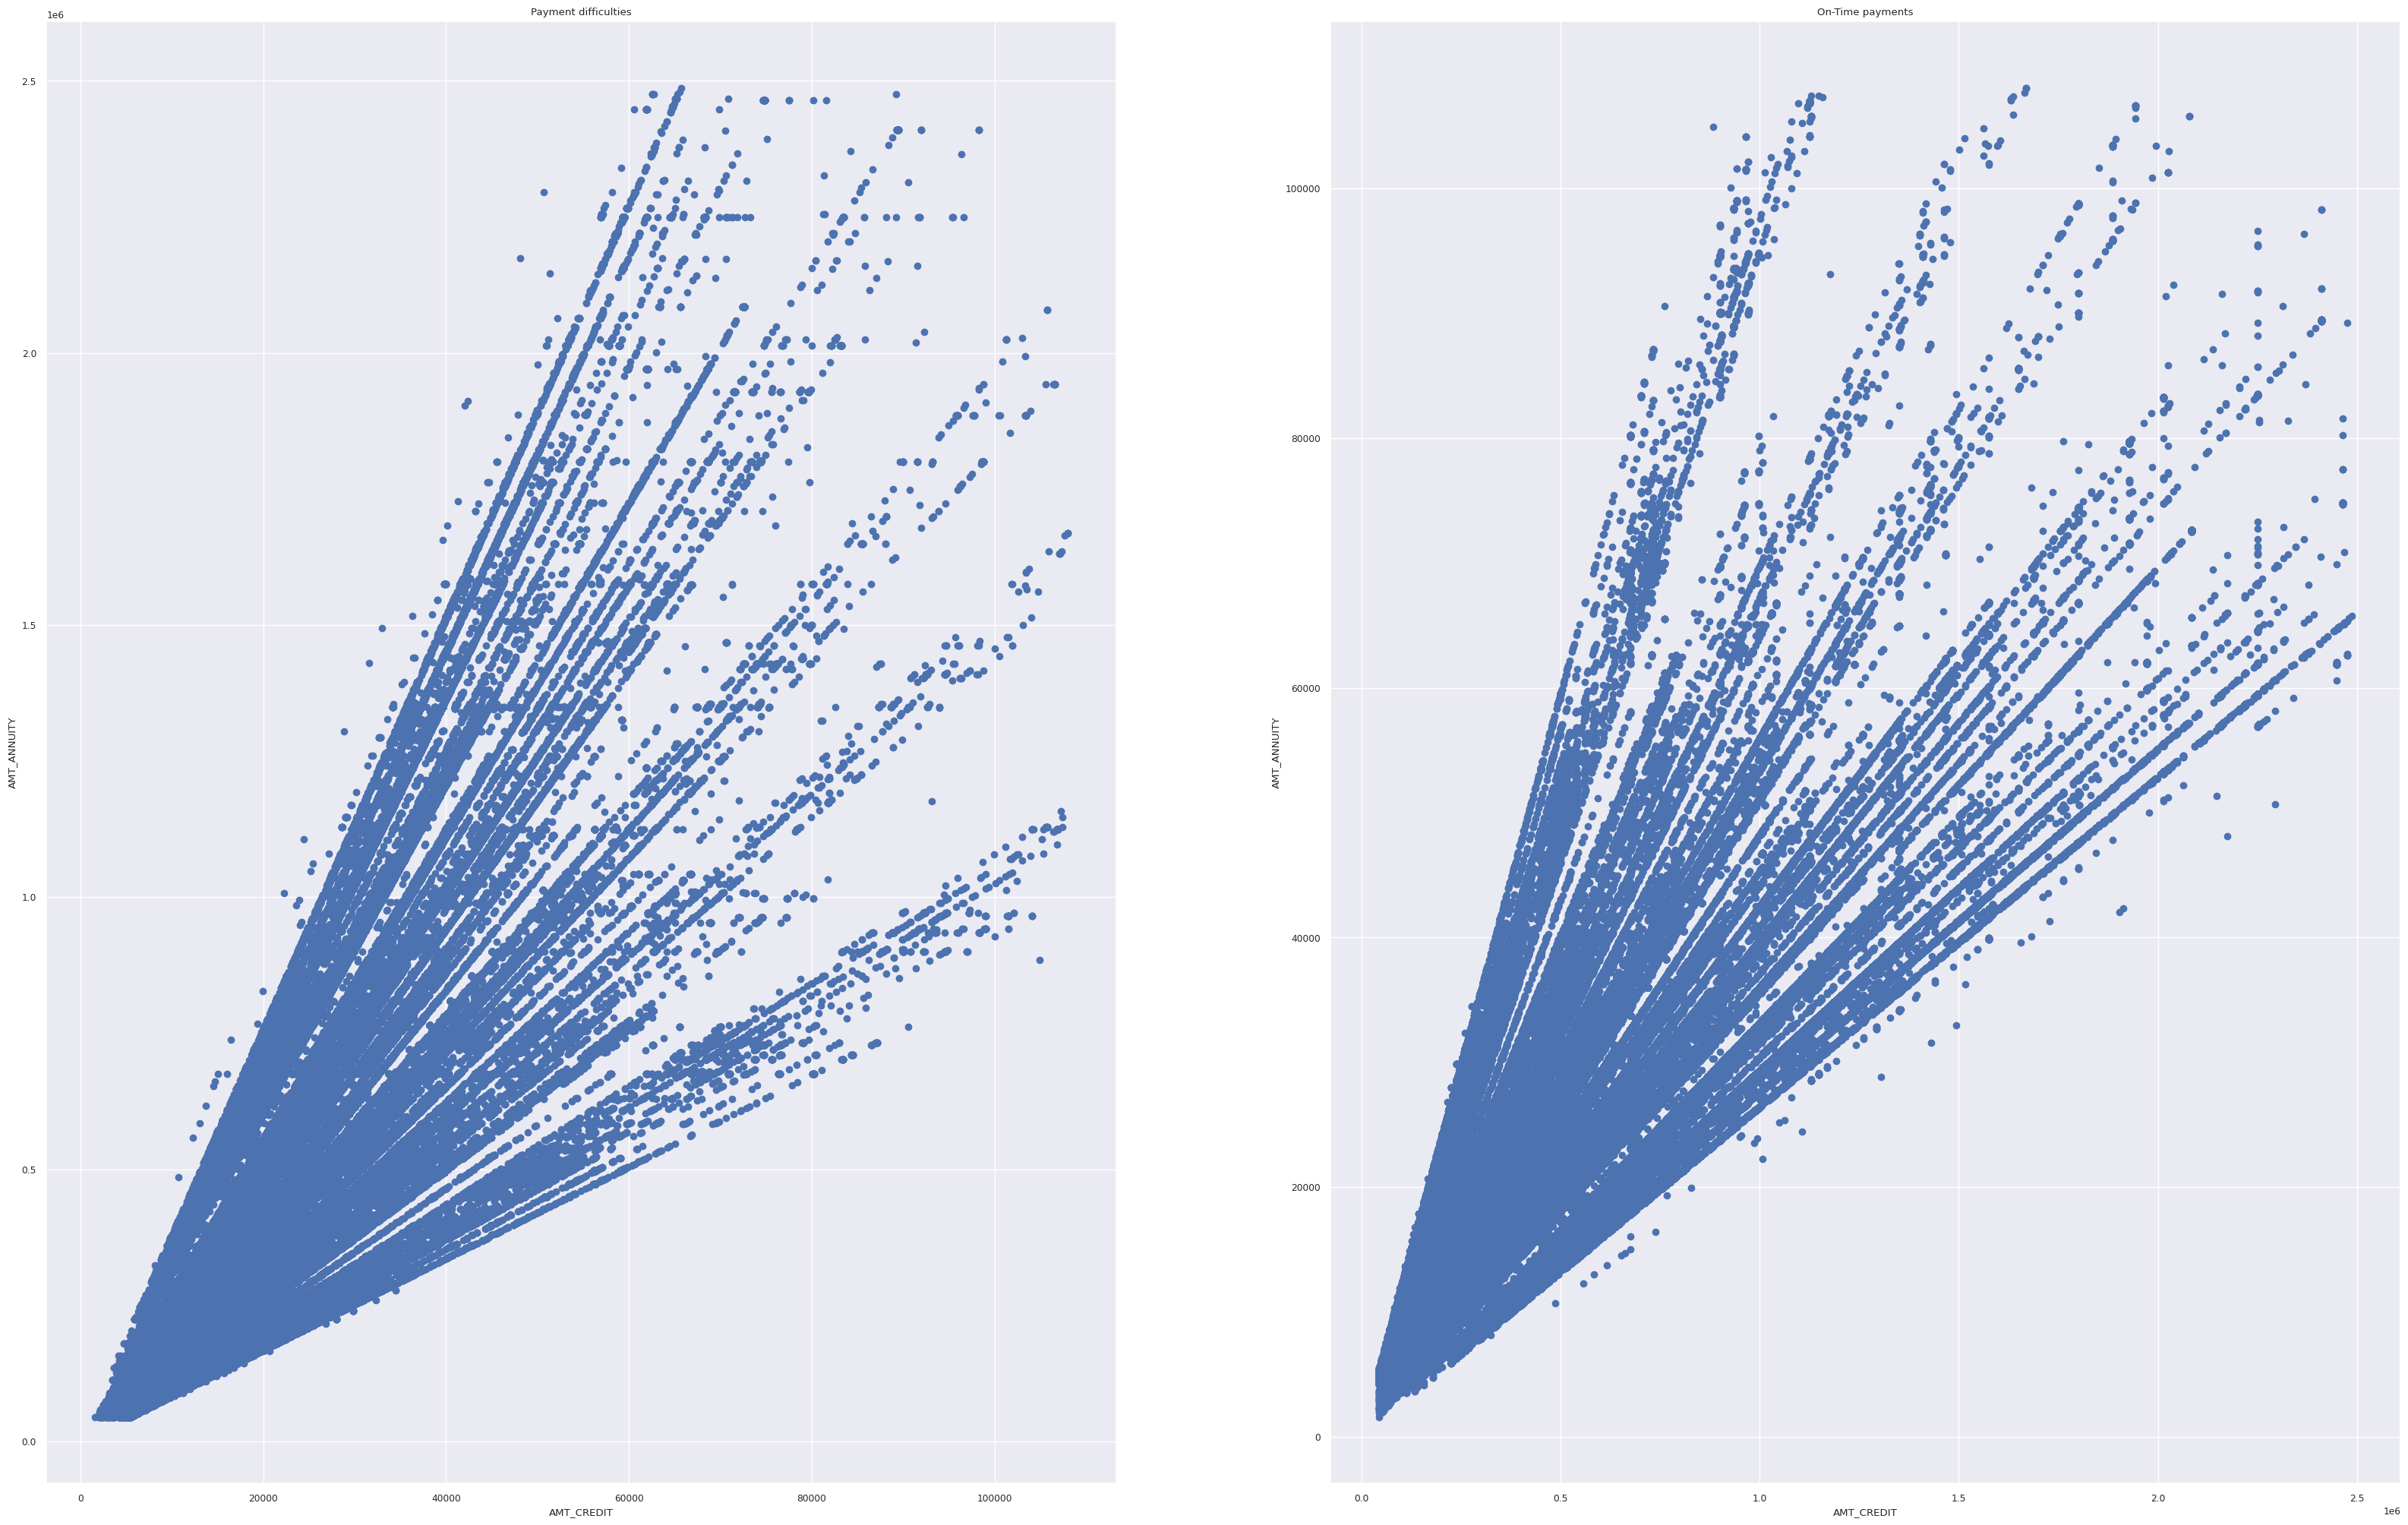

In [626]:
# 创建一个新的figure
# figsize是figure的大小，单位是inch, 你随便改改看看
fig, axs = plt.subplots(1, 2, figsize=(40, 25))

# 创建第一个散点图
# 我不知道你要的是什么关系
# 你有需要自己该参数. AMT_CREDIT和AMT_GOODS_PRICE你改为你要的
# 这两个图代码都一样, 就是参数你自己填填. 你该引号里的就行
axs[0].scatter(df['AMT_ANNUITY'], df['AMT_CREDIT'])
axs[0].set_title('Payment difficulties')
axs[0].set_xlabel('AMT_CREDIT')
axs[0].set_ylabel('AMT_ANNUITY')

# 创建第二个散点图
axs[1].scatter(df['AMT_CREDIT'], df['AMT_ANNUITY'])
axs[1].set_title('On-Time payments')
axs[1].set_xlabel('AMT_CREDIT')
axs[1].set_ylabel('AMT_ANNUITY')

plt.show()

In [627]:
# Merge with previous loan application data
app_merged = pd.merge(app, app_prev, how='left', on='SK_ID_CURR', suffixes=[None, "_PREV"])
app_merged['PREV_APP'] = app_merged['SK_ID_PREV'].notnull()
app_merged = app_merged.drop(app[(app['CODE_GENDER'] != 'M') & (app['CODE_GENDER'] != 'F')].index)
app_merged = app_merged.drop(app[(app['AMT_INCOME_TOTAL'] >= 1000000) & (app['AMT_INCOME_TOTAL'] >= 1000000)].index)

# Remap code for the payment difficulty column
app_merged.rename(columns={'TARGET': 'PMT_DIFF'}, inplace=True)
pmt_diff = {1: True, 0: False}
app_merged['PMT_DIFF'] = app_merged['PMT_DIFF'].map(pmt_diff)

# Filter out approved and non-approved applications
app_prev_merged = app_merged[app_merged["PREV_APP"] == True]
app_prev_approved = app_prev_merged[app_prev_merged['NAME_CONTRACT_STATUS'] == "Approved"]
app_prev_non_approved = app_prev_merged[app_prev_merged['NAME_CONTRACT_STATUS'] != "Approved"]

# Create a sample of customers in good standing and those in a risk category
good_cust = app_prev_approved[app_prev_approved['PMT_DIFF'] == False]
bad_cust = app_prev_non_approved[app_prev_non_approved['PMT_DIFF'] == True]


In [628]:
app.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          0.0               1                0   
1             -291          0.0               1                0   
2            -2531         26.0               1                1   
3            -2437          0.0               1                0   
4            -3458          0.0               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0       

In [629]:
app.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  306373.000000  306373.000000  306373.000000     306373.000000   
mean   278178.881961       0.080882       0.416251     166242.504881   
std    102793.318026       0.272654       0.716667      86839.291422   
min    100002.000000       0.000000       0.000000      25650.000000   
25%    189130.000000       0.000000       0.000000     112500.000000   
50%    278205.000000       0.000000       0.000000     144000.000000   
75%    367141.000000       0.000000       1.000000     202500.000000   
max    456255.000000       1.000000       6.000000     886500.000000   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.063730e+05  306373.000000     3.063730e+05   
mean   5.948992e+05   26905.415089     5.339946e+05   
std    3.942845e+05   13873.228376     3.617661e+05   
min    4.500000e+04    1615.500000     0.000000e+00   
25%    2.700000e+05   16501.500000     2.385000e+05   
50%    5.120640e+05   24853.500000     4.500000e+05   
75%    8.086500e+05   34555.500000     6.795000e+05   
max    2.487092e+06  108018.000000     2.475000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               306373.000000  306373.000000  306373.000000   
mean                     0.020830  -16036.467358   63961.761823   
std                      0.013771    4366.352251  141395.653928   
min                      0.000290  -25201.000000  -17912.000000   
25%                      0.010006  -19684.000000   -2757.000000   
50%                      0.018850  -15749.000000   -1211.000000   
75%                      0.028663  -12409.000000    -288.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE  FLAG_EMP_PHONE  \
count      306373.000000    306373.000000  306373.000000   306373.000000   
mean        -4987.649206     -2994.037742       4.101824        0.819530   
std          3523.489998      1509.310362       9.016756        0.384579   
min        -24672.000000     -7197.000000       0.000000        0.000000   
25%         -7481.000000     -4298.000000       0.000000        1.000000   
50%         -4505.000000     -3254.000000       0.000000        1.000000   
75%         -2011.000000     -1719.000000       5.000000        1.000000   
max             0.000000         0.000000      91.000000        1.000000   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count    306373.000000     306373.000000  306373.000000  306373.000000   
mean          0.199247          0.998162       0.280788       0.056591   
std           0.399435          0.042828       0.449385       0.231060   
min           0.000000          0.000000       0.000000       0.000000   
25%           0.000000          1.000000       0.000000       0.000000   
50%           0.000000          1.000000       0.000000       0.000000   
75%           0.000000          1.000000       1.000000       0.000000   
max           1.000000          1.000000       1.000000       1.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    306371.000000         306373.000000                306373.000000   
mean          2.151659              2.053663                     2.032754   
std           0.906482              0.508184                     0.501926   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max           8.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            306373.000000               306373.000000   
mean                 12.060139                    0.015040   
std                   3.26457

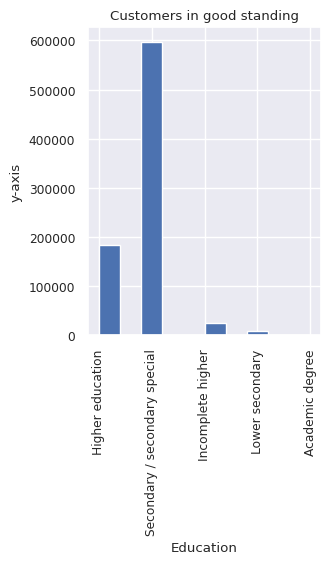

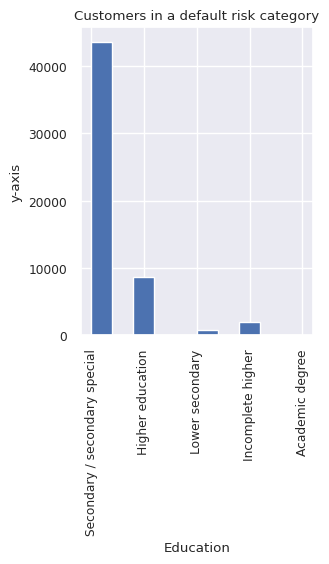

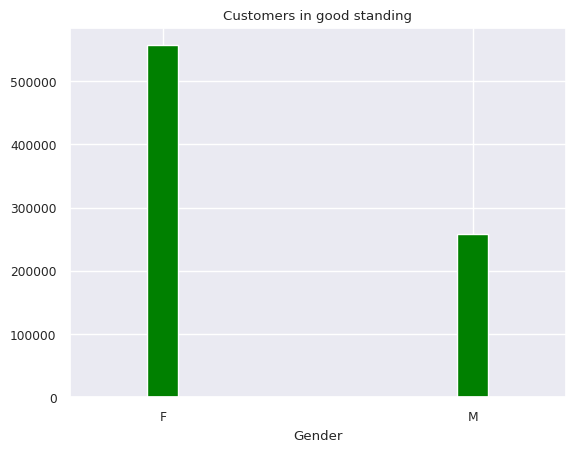

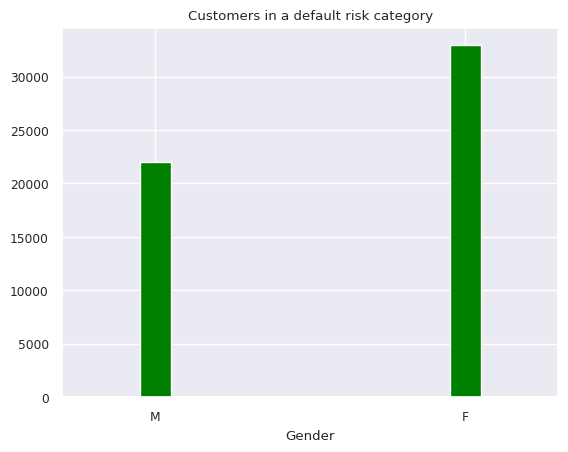

In [630]:
# Plot a histogram for customer education level comparison
fig, ax = plt.subplots(figsize=(3, 4))
ax.hist(good_cust['NAME_EDUCATION_TYPE'])
plt.title('Customers in good standing')
plt.xlabel("Education")
plt.ylabel("y-axis")
plt.xticks(rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(3, 4))
ax.hist(bad_cust['NAME_EDUCATION_TYPE'])
plt.title('Customers in a default risk category')
plt.xlabel("Education")
plt.ylabel("y-axis")
plt.xticks(rotation='vertical')
plt.show()

# Create a customer gender bar chart
good_cust['CODE_GENDER'].value_counts(sort=False).plot.bar(rot=0, color=['green'], width = 0.1)
plt.title('Customers in good standing')
plt.xlabel("Gender")
plt.show()
bad_cust['CODE_GENDER'].value_counts(sort=False).plot.bar(rot=0, color=['green'], width = 0.1)
plt.title('Customers in a default risk category')
plt.xlabel("Gender")
plt.show()

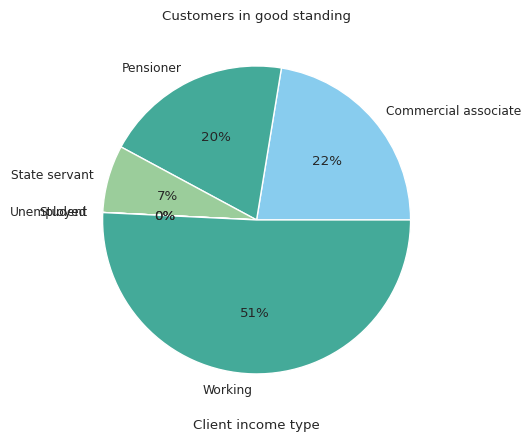

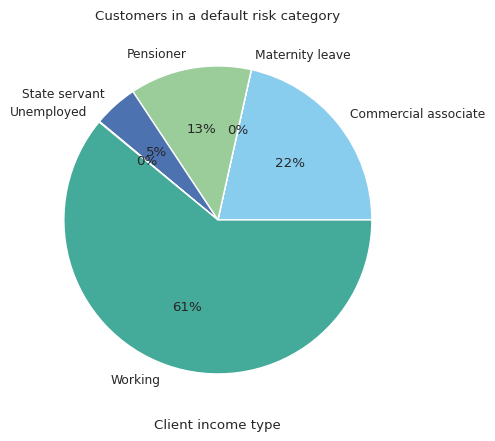

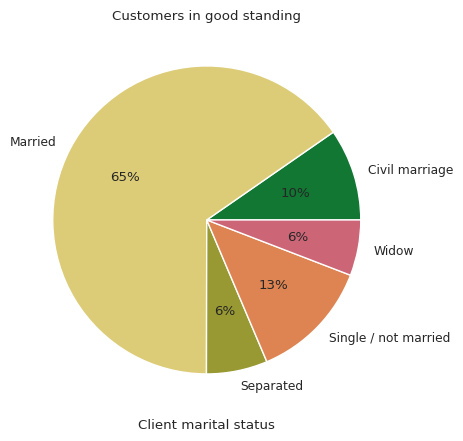

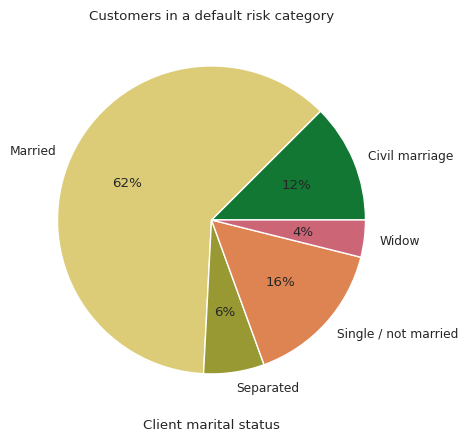

In [631]:
# Create a pie chart for client income type comparison
gc1 = good_cust.pivot_table(columns="NAME_INCOME_TYPE", fill_value=0, aggfunc="size")
ax = gc1.plot.pie(subplots=False, autopct='%1.0f%%', figsize=(10, 5), colors=['#88CCEE','#44AA99','#9BCD9B','#4C72B0'])
plt.title('Customers in good standing')
plt.xlabel("Client income type")
plt.show()

gc2 = bad_cust.pivot_table(columns="NAME_INCOME_TYPE", fill_value=0, aggfunc="size")
ax = gc2.plot.pie(subplots=False, autopct='%1.0f%%', figsize=(10, 5), colors=['#88CCEE','#44AA99','#9BCD9B','#4C72B0'])
plt.title('Customers in a default risk category')
plt.xlabel("Client income type")
plt.show()

# Create a pie chart for marital status comparison
gc1 = good_cust.pivot_table(columns="NAME_FAMILY_STATUS", fill_value=0, aggfunc="size")
ax = gc1.plot.pie(subplots=False, autopct='%1.0f%%', figsize=(10, 5), colors=['#117733','#DDCC77','#999933','#DD8452','#CC6677'])
plt.title('Customers in good standing')
plt.xlabel("Client marital status")
plt.show()

gc2 = bad_cust.pivot_table(columns="NAME_FAMILY_STATUS", fill_value=0, aggfunc="size")
ax = gc2.plot.pie(subplots=False, autopct='%1.0f%%', figsize=(10, 5), colors=['#117733','#DDCC77','#999933','#DD8452','#CC6677'])
plt.title('Customers in a default risk category')
plt.xlabel("Client marital status")
plt.show()

#app['NAME_CONTRACT_STATUS'].unique()
#list(app.columns)

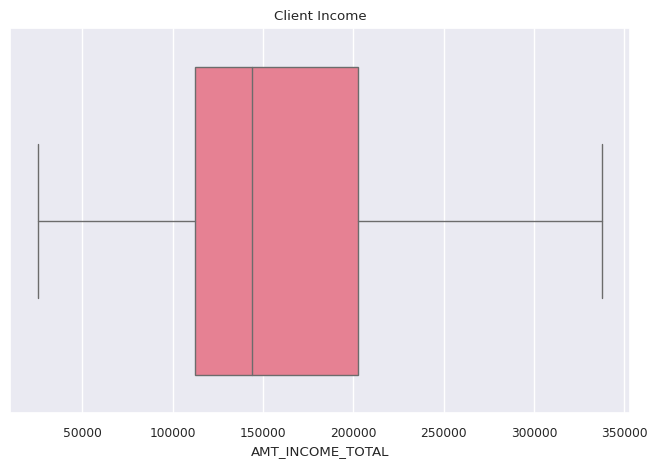

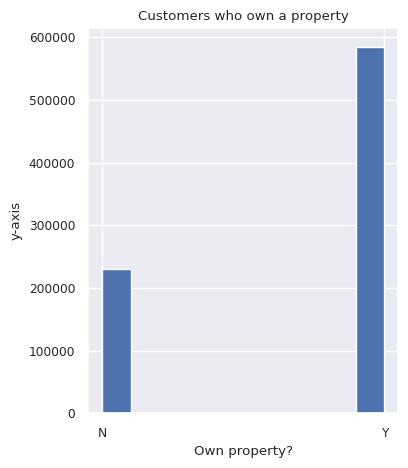

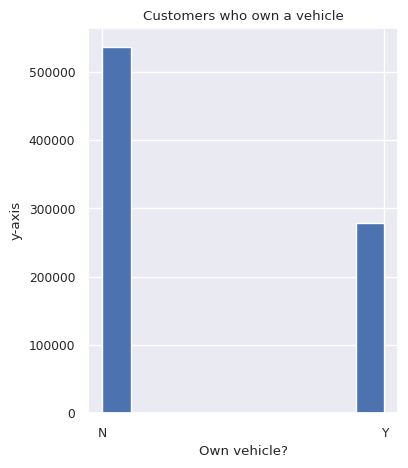

In [632]:
fig = plt.figure(figsize = (8,5))
sns.set(font_scale = 0.8)
ax=sns.boxplot(x='AMT_INCOME_TOTAL', data=app, linewidth=1, palette='husl', showfliers = False)
ax.set_title('Client Income')
plt.show()

# PLot a histogram for customers who own a property
fig, ax = plt.subplots(figsize=(4, 5))
ax.hist(good_cust['FLAG_OWN_REALTY'])
plt.title('Customers who own a property')
plt.xlabel("Own property?")
plt.ylabel("y-axis")
plt.xticks(rotation='horizontal')
plt.show()

# PLot a histogram for customers who own a car
fig, ax = plt.subplots(figsize=(4, 5))
ax.hist(good_cust['FLAG_OWN_CAR'])
plt.title('Customers who own a vehicle')
plt.xlabel("Own vehicle?")
plt.ylabel("y-axis")
plt.xticks(rotation='horizontal')
plt.show()

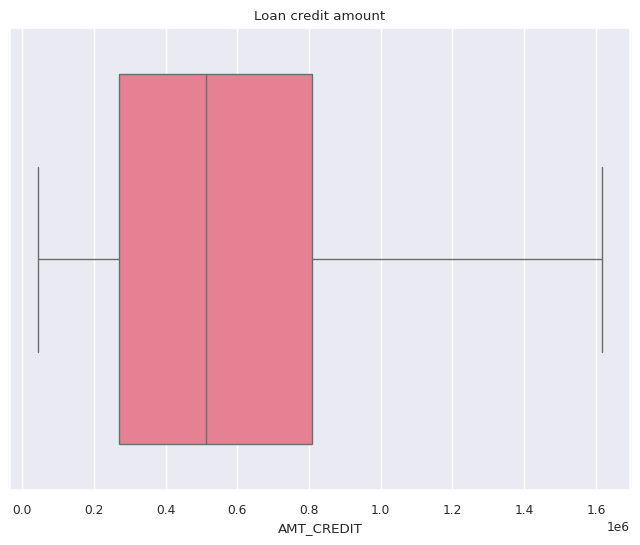

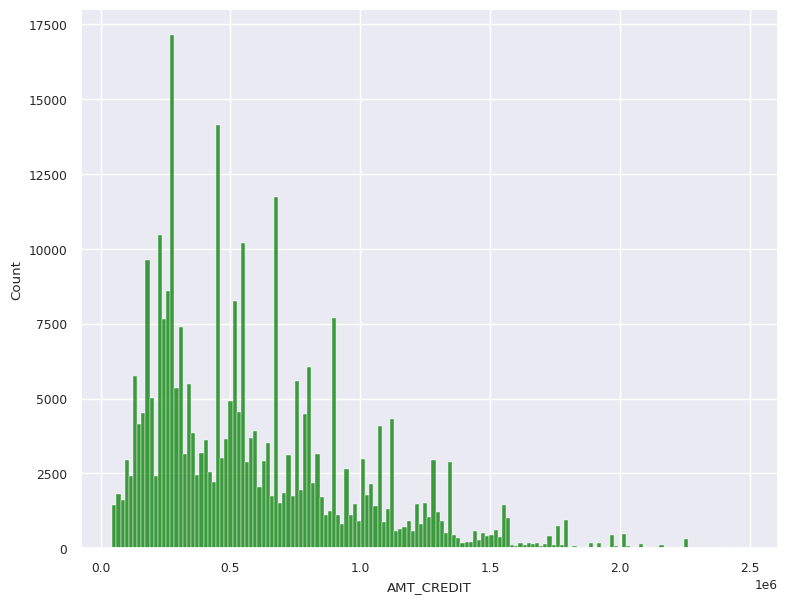

512064.0
594899.2413071648


In [633]:
# Create a box plot of credit amount
fig = plt.figure(figsize = (8,6))
sns.set(font_scale = 0.8)
ax=sns.boxplot(x='AMT_CREDIT', data=app, linewidth=1, palette='husl', showfliers = False)
ax.set_title('Loan credit amount')

# Create a histogram of credit amount
fig = plt.figure(figsize = (9,7))
sns.histplot(app['AMT_CREDIT'].dropna(), color ='green')
ax.set_title('Loan credit amount')
plt.show()

print(app['AMT_CREDIT'].median())
print(app['AMT_CREDIT'].mean())

# Decision tree for previous_application

In [ ]:
old_data = pd.read_csv("previous_application.csv", nrows=80000)

In [ ]:
old_data.head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [ ]:
selected_columns = old_data.loc[:, ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE','NFLAG_INSURED_ON_APPROVAL', 'NAME_CONTRACT_STATUS' ]]

We selected columns that would make total sense. in the followng code we will classify the prev_customer data.

In [ ]:
selected_columns

AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  \
0         1730.430          17145.0     17145.0               0.0   
1        25188.615         607500.0    679671.0               NaN   
2        15060.735         112500.0    136444.5               NaN   
3        47041.335         450000.0    470790.0               NaN   
4        31924.395         337500.0    404055.0               NaN   
...            ...              ...         ...               ...   
79995     4944.510          34645.5     31176.0            5400.0   
79996     3771.315          34875.0     38326.5               0.0   
79997          NaN         105205.5    105205.5               0.0   
79998    14309.595         209785.5    131643.0           90000.0   
79999    31209.030         254070.0    273523.5               0.0   

       AMT_GOODS_PRICE  NFLAG_INSURED_ON_APPROVAL NAME_CONTRACT_STATUS  
0              17145.0                        0.0             Approved  
1             607500.0                        1.0             Approved  
2             112500.0                        1.0             Approved  
3             450000.0                        1.0             Approved  
4             337500.0                        NaN              Refused  
...                ...                        ...                  ...  
79995          34645.5                        1.0             Approved  
79996          34875.0                        0.0             Approved  
79997         105205.5                        NaN              Refused  
79998         209785.5                        1.0             Approved  
79999         254070.0                        1.0             Approved  

[80000 rows x 7 columns]

In [ ]:
selected_columns['AMT_DOWN_PAYMENT'] = selected_columns['AMT_DOWN_PAYMENT'].fillna(0.0)
selected_columns['NFLAG_INSURED_ON_APPROVAL'] = selected_columns['NFLAG_INSURED_ON_APPROVAL'].fillna(0.0)

The reason why we changed the null values into 0.0 in AMT_DOWN_PAYMENT attribute is that some collumns has data in it already, the rest had NAN because they were loans and if you are getting loan to use in your expence the idea of down payment does not apply. So changing it to 0 rather than deleting the rows made the data efficient.

In [ ]:
selected_columns.isnull().sum()

AMT_ANNUITY                  16976
AMT_APPLICATION                  0
AMT_CREDIT                       0
AMT_DOWN_PAYMENT                 0
AMT_GOODS_PRICE              17305
NFLAG_INSURED_ON_APPROVAL        0
NAME_CONTRACT_STATUS             0
dtype: int64

In [ ]:
clean_df = selected_columns.dropna()

making sure that the data did not contain nulls that could mislead the classifier.

In [ ]:
clean_df.isnull().sum()

AMT_ANNUITY                  0
AMT_APPLICATION              0
AMT_CREDIT                   0
AMT_DOWN_PAYMENT             0
AMT_GOODS_PRICE              0
NFLAG_INSURED_ON_APPROVAL    0
NAME_CONTRACT_STATUS         0
dtype: int64

In [ ]:
X = clean_df[['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE','NFLAG_INSURED_ON_APPROVAL']]
y = clean_df['NAME_CONTRACT_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8161837339479749
Confusion Matrix:
[[8870   10  980    7]
 [  12    0   17    0]
 [1193    7 1044    0]
 [   7    0    0    1]]


With the following code we can say that using this attributes used on this classifier potentially accurately predict 81% of all customers.